# Macro III - Problem Set 04 - Aiyagari Model

Vinícius de Almeida Nery Ferreira

October 4th, 2024

In [1]:
# Importing packages
## Data
import numpy as np
import pandas as pd

## Plots
import matplotlib.pyplot as plt
plt.style.use('bmh')

## Other
import random
import time
from tqdm import tqdm
from numba import njit  # makes things faster

## Methods
from scipy.optimize import fsolve, brentq, newton, root
from quantecon.markov.approximation import rouwenhorst, tauchen

# Setting seeds for random
random.seed(121019)
np.random.seed(121019)

In [2]:
# Ignoring rouwenhorst warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

We will study the **Aiyagari Model**.

As in the Huggett model, we don't have complete markets, in the sense that agents can't buy state-contingent bonds.

Thus, agents are hit by idiosyncratic shocks that are only *partially insurable*.
This leads to ex-ante identical agents being **heterogenous ex-post**.

Contrary to Huggett, in Aiyagari's model households not only underwrite debt contracts to each other, but also rent capital and labor to firms.

This means that we can have positive savings and, thus, *capital accumulation* in the economy.

Furthermore, wages are no longer simple endowments, but paid by firms in a competitive market and determined by leisure preferences.

# (a) Shock Space

## Discretization

We have a high persistence parameter ($\rho = .98$).
For this reason, we will use Rouwenhorst's method, as it is better in approximating highly persistent process.

Note that, in this way, we don't fully follow the question in allowing for the discrete grid to span three standard deviations the labor endowment process.

In [3]:
# Defining parameters
rho = .98
variance_z = .621

variance_error = variance_z * (1 - rho ** 2)
print(f"Variance of Error of Markov Process: {round(variance_error, 3)}")
print(f"Standard Deviation of Error of Markov Process: {round(variance_error ** (1 / 2), 3)}")

# Grid length
num_shocks = 7

Variance of Error of Markov Process: 0.025
Standard Deviation of Error of Markov Process: 0.157


In [4]:
# Discretizing the AR1 of log shock: this happens to make a huge different
# due to the span of the shock in Tauchen's method.
method = 'rouwenhorst'  # rouwenhorst, tauchen

if method == 'tauchen':
    discrete_ln_shock = tauchen(
        n=num_shocks, 
        rho=rho, 
        sigma=variance_error**(1 / 2), 
        mu=0,
        n_std=3
    )
else:
    discrete_ln_shock = rouwenhorst(
        n=num_shocks, 
        rho=rho, 
        sigma=variance_error**(1 / 2), 
        mu=0
    )

In [5]:
# Getting state grid and transition matrix of ln(z)
state_grid_ln_shock = discrete_ln_shock.state_values
state_grid_shock = np.exp(state_grid_ln_shock)
transition_matrix = discrete_ln_shock.P

In [6]:
# Printing transition matrix
print(np.around(transition_matrix, 3))

[[0.941 0.057 0.001 0.    0.    0.    0.   ]
 [0.01  0.942 0.048 0.001 0.    0.    0.   ]
 [0.    0.019 0.942 0.038 0.001 0.    0.   ]
 [0.    0.    0.029 0.942 0.029 0.    0.   ]
 [0.    0.    0.001 0.038 0.942 0.019 0.   ]
 [0.    0.    0.    0.001 0.048 0.942 0.01 ]
 [0.    0.    0.    0.    0.001 0.057 0.941]]


In [7]:
# Printing values for each state
print("Values for labor efficiency endowment (in level, not log):")
print(np.around(state_grid_shock, 3))

Values for labor efficiency endowment (in level, not log):
[0.145 0.276 0.525 1.    1.903 3.621 6.891]


## Stationary Distribution of Shock

To calculate the stationary distribution of the process, we basically have to find the eigenvector associated with the transition matrix.
We can also do it via simulation, which is what we will do.

In [8]:
def get_stationary_distribution_shocks(transition_matrix, max_iter=10_000, 
                                       tol=1e-12, print_convergence=True):
    """
    Calculathes the stationary distribution of shocks, which is the same
    as the eigenvector of the transition matrix.
    """
    
    # Dimensions
    num_shocks = transition_matrix.shape[0]

    # Guess for initial distribution
    v = np.ones(num_shocks) / num_shocks

    # Iterating until we converge to the stationary distribution
    for num_iter in range(max_iter):
        # New distribution
        ## v by default is a column vector, not a row: instead of computing vP = v as in slides,
        ## we calculate P'v' = v', where v is the row vector in slides (v': column)
        v_new = transition_matrix.T @ v

        # Checking sup norm
        if np.max(np.abs(v - v_new)) < tol:
            break
        else:
            v = v_new.copy()
    
    # Assessing convergence
    if print_convergence is True:
        if num_iter >= max_iter - 1:
            print(f"Distribution of shocks did not converge in {max_iter} iterations.")
        else:
            print(f"Distribution of shocks converged in {num_iter} iterations.")

    return v_new

In [9]:
# Calculating stationary distribution
stationary_dist_shocks = get_stationary_distribution_shocks(transition_matrix)

# Printing
print("\nStationary distribution of shocks:")
print(np.around(stationary_dist_shocks, 3))

Distribution of shocks converged in 576 iterations.

Stationary distribution of shocks:
[0.016 0.094 0.234 0.312 0.234 0.094 0.016]


## Simulating the Markov Chain

In [10]:
# Function from Problem Set 02
def simulate_markov_chain(state_grid, transition_matrix, T,
                          initial_value=None):
    """
    Simulates a Markov chain of length T given its characterization objects
    (state_grid, transition_matrix).
    If passed, initial_value must be an element of state_grid.
    """

    # Getting number of states
    N = state_grid.shape[0]

    # Computing cumulative distribution of the markov chain
    ## Skeleton
    cdf_markov_matrix = np.zeros([N, N])

    ## Looping
    for i in range(N):
        for j in range(N):
            # Summing row i of transition matrix until column j
            cdf_markov_matrix[i, j] = np.sum(transition_matrix[i, :j + 1])
    
    # Skeleton of markov process
    simulated_values = np.zeros(T)

    # Initial state
    ## If not specified, create at random
    if initial_value is None:
        index_state_today = np.random.choice(N)
        state_today = state_grid[index_state_today]
        simulated_values[0] = state_today
    ## If specified, use it as the initial state and grab its index in the grid
    else:
        index_state_today = np.where(state_grid == initial_value)[0][0]
        simulated_values[0] = initial_value

    # Simulating
    for t in range(1, T):
        # Getting random index with probabilities associated to current state
        # transition_matrix[index_state_today]: row i of transition matrix (sums to 1)
        index_state_tomorrow = np.random.choice(
            N, p=transition_matrix[index_state_today]
        )

        # State tomorrow
        state_tomorrow = state_grid[index_state_tomorrow]

        # Adding to array
        simulated_values[t] = state_tomorrow

        # Updating index
        index_state_today = index_state_tomorrow
    
    # Returning simulation
    return simulated_values

In [11]:
# Simulating log(labor endowments) shocks starting at 0
## Number of periods
T_markov = 10000

## Path
simulated_shock_path = simulate_markov_chain(
    state_grid=state_grid_ln_shock, 
    transition_matrix=transition_matrix, 
    T=T_markov,
    initial_value=0
)

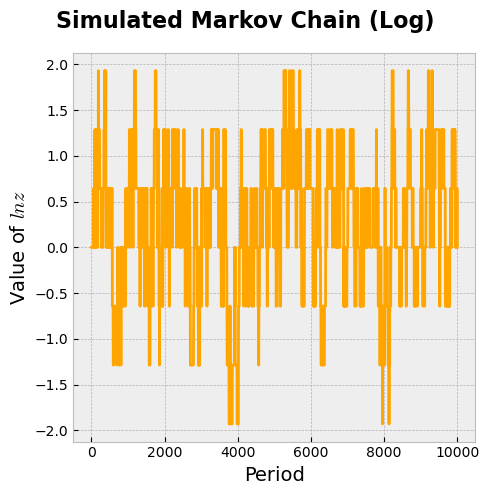

In [12]:
# Plotting
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
fig.suptitle("Simulated Markov Chain (Log)", 
             fontsize=16, fontweight='bold')

ax.plot(range(T_markov), simulated_shock_path, 
        label=r"$\rho = 0.9$", color='orange')
ax.set_xlabel("Period", fontsize=14)
ax.set_ylabel(r"Value of $ln z$", fontsize=14)

plt.tight_layout()
plt.show()

In [13]:
# Sample metrics (without dof correction)
mean_markov_simulated = np.mean(simulated_shock_path)
var_markov_simulated = np.var(simulated_shock_path, ddof=0)

# Printing
print(f"Markov Process of Log z:")
print(f"True Mean: {0} | Sample Mean: {round(mean_markov_simulated, 2)}")
print(f"True Variance: {round(variance_z, 2)} | Sample Variance: {round(var_markov_simulated, 2)}")

Markov Process of Log z:
True Mean: 0 | Sample Mean: 0.28
True Variance: 0.62 | Sample Variance: 0.59


Rouwehorst's method does a fairly good job in approximating the variance of the process, but the mean is a little bit of.

# (b) Households' Problem

*NOTE*: we will solve the model with endogenous labor supply, treating the simpler case of exogenous labor as a particular case with $\chi = 0$ and $h_t = 1$ $\forall t$.

We have a continuum of infinitely lived households of measure 1.
In each period, they choose how much to consume $c_t \in \mathbb{R}_+$, how much to save in assets $a_{t+1} \in \mathbb{R}$ and how much to work $h_t \in \mathbb{R}_+$.

They earn income from labor and previously saved assets, taking prices $(w_t, r_t) \in \mathbb{R}^2$ as given.
However, their labor supply is subject to an idiosyncratic shock $z_t$, such that their effective labor supply is $z_t h_t$.

They are subject to a borrowing constraint of $\phi$, with $\phi \geq 0$. Thus, $a_t \geq \phi$ for all $t$.

The household's problem is 

$$
\max_{\{c_t, h_t, a_{t+1}\}_{t=0}^{\infty}} \mathbb{E}_0 \sum_{t=0}^{\infty} \beta^t u(c_t, h_t),
$$

subject to

$$
\begin{cases}
c_t + a_{t+1} = (1 + r_t) a_t + z_t h_t w_t \\
\ln z_{t + 1} = \rho \ln z_t + \varepsilon_{t + 1} \\
a_{t + 1} \geq \phi
\end{cases}
$$

where $u(c_t, h_t) = \frac{1}{1 - \sigma} \left( c_t - \chi \frac{h_t^{1 + \varphi}}{1 + \varphi} \right)^{1 - \sigma}$ and $\mathbb{E}_0$ denotes the expected value conditional on the information set at period 0.
Note that, if $\chi = 0$, the utility reduces to the case of exogenous labor supply: $u(c_t) = \frac{c_t^{1 - \sigma}}{1 - \sigma} $

Finally, $\varepsilon_t \sim N (0, \sigma_{\varepsilon}^2)$.
Assume $\rho = .98$ and $\sigma_z^2 = \frac{\sigma_{\varepsilon}^2}{1 - \rho^2} = 0.621$.

We can write the problem in recursive form:

$$
V(z, a) = \max_{c, h, a'} \left\{u(c,h) + \beta \mathbb{E}\left[ V(z', a') \mid z\right] \right\}
$$

subject to

$$
\begin{cases}
c + a' = (1 + r) a + z h w \\
\ln z' = \rho \ln z + \varepsilon' \\
a' \geq \phi
\end{cases}
$$

# (c) Firms' Problem

Firms are homogeneous, hiring workers at wage rate $w$ and renting capital at rate $\tilde{r}$.

The representative firm solves

$$
\max_{K,H} K^{\alpha}H^{1-\alpha} - wH - \tilde{r}K
$$

so that

$$
\tilde{r} = \alpha \left( \frac{K}{H} \right)^{\alpha - 1}
$$

and

$$
w = (1 - \alpha) \left( \frac{K}{H} \right)^{\alpha}
= (1 - \alpha) \left( \frac{\alpha}{\tilde{r}} \right)^{\frac{\alpha}{1 - \alpha}}
$$

# (d) Recursive Competitive Equilibrium

From Lecture 7, a recursive stationary equilibrium consists of:

- time invariant prices $w$ and $r$;
- a value function $V(z_i, a)$;
- optimal decision rules $a'(z_i, a)$, $c(z_i, a)$, and $h(z_i, a)$;
- an invariant distribution function $\lambda(z_i, a)$;
- a vector of aggregates: $K, L$;

such that

1. **Consumer optimization**: given the prices $r$ and $w$, $V(z_i, a)$ is a solution of the individual problem and $a'(z_i, a)$, $c(z_i, a)$, and $h(z_i, a)$ are the associated optimal decision rules;

2. **Firm’s optimization**: prices $r$ and $w$ satisfy:
    $$
    r = F_K(K, L) - \delta = \alpha \left( \frac{K}{N} \right)^{\alpha - 1} - \delta \text{ (by arbitrage)}
    $$
    $$
    w = F_L(K, L) = (1 - \alpha) \left( \frac{K}{N} \right)^{\alpha} = (1 - \alpha) \left( \frac{\alpha}{\tilde{r}} \right)^{\frac{\alpha}{1 - \alpha}}
    $$

3. **Consistency**: $\Phi(z_i, a)$ is a stationary distribution consistent with the optimal decision rule $a'(z_i, a)$ and the Markov chain $(Z, \Pi)$;

4. **Aggregation**: The aggregate capital stock and labor supply are consistent with $F(z_i, a)$:

    $$
    K = \sum_{i=1}^{n_z} \int_A a d\lambda(z_i, a)
    $$
    $$
    L = \sum_{i=1}^{n_z} \int_A h(z_i, a) z_i d\lambda(z_i, a)
    $$

The functional form assumption on the utility function much simplifies our life.
Note that the intra-temporal condition of the problem is

$$
\frac{\partial c}{\partial h} u_c(c, h) + u_h(c, h) = 0
\quad \therefore \quad
wz u_c(c, h) = - u_h(c, h)
\tag{Intratemporal}
$$

Furthermore, the FOC of the Bellman equation with respect to $a'$ is

$$
\frac{\partial c}{\partial a'} u_c(c, h) + \beta \mathbb{E}\left[ V_a(z', a') \mid z\right] = 0
\quad \therefore \quad
u_c(c, h) = \beta \mathbb{E}\left[ V_a(z', a') \mid z\right]
\tag{Bellman FOC}
$$

As $u(c, h) = \frac{1}{1 - \sigma} \left( c - \chi \frac{h^{1 + \varphi}}{1 + \varphi} \right)^{1 - \sigma}$, we have

$$
u_c(c,h) = \left(c - \chi \frac{h^{1+\varphi}}{1+\varphi} \right)^{-\sigma}
$$

and

$$
u_h(c,h) = -\chi h^{\varphi} \left(c - \chi \frac{h^{1+\varphi}}{1+\varphi} \right)^{-\sigma}
$$

Substituting in *(Intratemporal)*, we can get the policy function for labor supply

$$
wz \left(c - \chi \frac{h^{1+\varphi}}{1+\varphi} \right)^{-\sigma} = \chi h^{\varphi} \left(c - \chi \frac{h^{1+\varphi}}{1+\varphi} \right)^{-\sigma}
\quad \therefore \quad
h (z, a) = \left( \frac{wz}{\chi} \right)^{\frac{1}{\varphi}}
$$

Note that $h(z, a)$ does not depend on $a$, $a'$ or $c$, which will make things a lot easier.

Thus, the labor-leisure choice is an instantaneous decision and does not affect the future value directly.

For the FOC of the Bellman Equation, recall that the Envelope Condition implies

$$
V_a (z, a) = u_a(c, h) = \frac{\partial c}{\partial a} u_c(c, h) = (1 + r) \left(c - \chi \frac{h^{1+\varphi}}{1+\varphi} \right)^{-\sigma}
\tag{Envelope}
$$

We can substitute in *(Bellman)* to get a implicit definition for consumption:

$$
\begin{align*}
u_c(c, h) &= \left(c - \chi \frac{h^{1+\varphi}}{1+\varphi} \right)^{-\sigma} = \beta \mathbb{E}\left[ V_a(z', a') \mid z\right] &&\\
& \iff c = \left( \beta \mathbb{E}\left[ V_a(z', a') \mid z\right] \right)^{-\frac{1}{\sigma}} + \chi \frac{h^{1+\varphi}}{1+\varphi}
\end{align*}
$$

# (e) VFI

We now solve the model with the VFI method.
Note that both our VFI and EGM can handle endogenous and exogenous labor supplies.

Furthermore, the VFI does not explore any differentiability or monotonicity which we detailed in the previous item.

First, we define the parameters of the question.

## Parameters

In [14]:
# Defining parameters
beta = .96
sigma = 2
chi = 0 # 0 means no endogenous labor supply, inelastic labor
varphi = 3
alpha = .4
delta = .08

In [15]:
# Fixed interest rate for the first few exercises
r_value = 0.02

In [16]:
# Dictionary for exogenous parameters
param_dict = {
    'beta': beta,
    'sigma': sigma,
    'chi': chi,
    'alpha': alpha,
    'delta': delta,
    'varphi': varphi
}

In [17]:
# Dictionary for exogenous parameters with higher beta
beta_alt = 0.975

param_dict_alt = {
    'beta': beta_alt,
    'sigma': sigma,
    'chi': chi,
    'alpha': alpha,
    'delta': delta,
    'varphi': varphi
}

## State Grid

In [18]:
# Parameters
phi = 0 # borrowing constraint
a_max = 100
num_states = 1000

In [19]:
# Linear grid
linear_state_grid = np.linspace(phi, a_max, num_states)

## Labor Functions

Recall that

$$
w = (1 - \alpha) \left( \frac{K}{N} \right)^{\alpha}
= (1 - \alpha) \left( \frac{\alpha}{\tilde{r}} \right)^{\frac{\alpha}{1 - \alpha}}
$$

$$
h (z, a) = \left( \frac{wz}{\chi} \right)^{\frac{1}{\varphi}}
$$

and that the actual (or "effective") labor supply is $z \cdot h$.

Note that, by arbitrage, $\tilde{r} = r + \delta$.

In [20]:
def get_wage(r, param_dict):
    # Getting parameters
    alpha = param_dict['alpha']
    delta = param_dict['delta']

    # Recall that r~ = r (bonds) + delta by arbitrage
    return (1 - alpha) * (alpha / (r + delta)) ** (alpha / (1 - alpha))

In [21]:
def get_policy_h(r, z, param_dict):
    # Getting parameters
    chi = param_dict['chi']
    varphi = param_dict['varphi']

    # Dimensions: on the EGM function, z is an array, while on the VFI routine
    # it is a scalar. Did it this way to use the same function in both.
    try:
        num_shocks = z.shape[0]
    except IndexError:
        num_shocks = np.array([z]).shape[0]

    # Calculating wage
    w = get_wage(r, param_dict)

    # Calculating and returning h; if we don't have endogenous labor, supply is inelastic (= 1)
    h = np.ones(shape=num_shocks) if chi == 0 else (w * z/ chi)**(1 / varphi)
    
    return h

In [22]:
def get_effective_labor(r, z, param_dict):
    # Getting policy labor
    h = get_policy_h(r, z, param_dict)

    # Returning effective labor (just z in the exogenous case)
    return z * h

## Consumption and Utility Functions

In [23]:
def consumption_asset(a, a_prime, r, z, param_dict):
    """ 
    Calculates consumption as a function of assets today, tomorrow, wages
    and parameters through the budget constraint.
    """

    # Calculating wage and effective labor
    w = get_wage(r, param_dict)
    effective_labor = get_effective_labor(r, z, param_dict)

    # Calculating consumption by the budget constraint
    consumption = (1 + r) * a + w * effective_labor - a_prime

    # Consumption has to be positive
    consumption = np.maximum(consumption, 1e-6)

    # Returning
    return consumption

In [24]:
def utility_asset(a, a_prime, r, z, param_dict):
    """ 
    Calculates utility as a function of assets today, tomorrow and parameters
    """

    # Getting parameters
    sigma = param_dict['sigma']
    chi = param_dict['chi']
    varphi = param_dict['varphi']

    # Optimal labor
    labor = get_policy_h(r, z, param_dict)

    # Calculating consumption
    consumption = consumption_asset(a, a_prime, r, z, param_dict)

    # Utility
    return (1 / (1 - sigma)) * (consumption - chi * labor**(1 + varphi) / (1 + varphi)) ** (1 - sigma)

In [25]:
def get_utility_conditional_on_shock(a, a_prime, r, z, param_dict):
    """
    Calculates utility matrices as a function of assets today, tomorrow
    and parameters, conditional on each value of employment.
    Returns an array of matrices of utility for each possible combination of a, a_prime and shock
    """
    
    # Number of shocks and capital states
    n_shock_space = z.shape[0]
    n_asset_space = a.shape[0]

    # Array
    conditional_utility_array = np.zeros([n_shock_space, n_asset_space, n_asset_space])

    # Loop to fill arrays
    for index in range(n_shock_space):
        # Calculating consumption and utility
        ## Recall we want a today in the columns and a' tomorrow in the rows, so we transpose at the end
        conditional_utility_array[index] = utility_asset(
            a=a, 
            a_prime=a_prime, 
            r=r, 
            z=z[index], 
            param_dict=param_dict
        ).T

    # Returning
    return conditional_utility_array

## Value Function

Same function from previous Problem Sets, but now calculating policy functions inside it.

In [26]:
def value_function_iteration(r, a_space, shock_space, shock_transition_matrix,
                             param_dict, tol=1e-6, max_iter=5000):
    """
    Iterating through vectors (function approximations) until we reach a fixed point conditional on all shocks.
    """

    # Parameters
    beta = param_dict['beta']

    # Assuring spaces are arrays
    a_space = np.array(a_space)
    shock_space = np.array(shock_space)

    # Getting dimensions of matrices and vectors
    num_asset_spaces = a_space.shape[0]
    num_shock_spaces = shock_space.shape[0]

    # Initial guess
    ## Matrix of conditional value functions (or approximations of it using vectors)
    ## for every a and z, it should give the maximum value attained
    V = np.zeros([num_shock_spaces, num_asset_spaces])
    V_new = np.zeros([num_shock_spaces, num_asset_spaces])

    ## Skeleton to store optimal indexes for policy function
    optimal_indexes = np.zeros([num_shock_spaces, num_asset_spaces])
    policy_a = np.zeros([num_shock_spaces, num_asset_spaces])
    policy_c = np.zeros([num_shock_spaces, num_asset_spaces])

    # Creating meshgrid, which give coordinates of a and a'
    a_matrix, a_prime_matrix = np.meshgrid(a_space, a_space)

    # Array with utilities for each possible combination of a, a' and shock value
    ## For each shock value (first dimension), returns a matrix of utility for space tomorrow
    ## in rows (second dimension) and state today in columns (third dimension)
    u_array_conditional_shock = get_utility_conditional_on_shock(
        a=a_matrix, 
        a_prime=a_prime_matrix, 
        r=r, 
        z=shock_space, 
        param_dict=param_dict
    )

    # Iterating
    for num_iter in tqdm(range(max_iter)):
        # Calculating matrix of possible values of V: for every state today (column),
        # what is the value of each state tomorrow (row) conditional on each shock

        ## Loop
        for index_shock in range(num_shock_spaces):
            # Expected value tomorrow
            expected_V_tomorrow = shock_transition_matrix[[index_shock]] @ V

            # Transforming into a vector
            expected_V_tomorrow = expected_V_tomorrow[0, :]

            ## Important: in numpy, operations between matrices (first term) and vectors (second term)
            ## are done column-wise. That is, we add B * V(a', z') to each column, which is exactly 
            ## what we want, as rows represent a' (see matrix on slide 27 of Lecture 4)
            matrix_state_values = u_array_conditional_shock[index_shock] + beta * expected_V_tomorrow

            # Calculating maximum value for each state today (columns, axis=1)
            # That is, for each column, we are grabbing the row (next state) which maximizes V for that state
            # (conditional on the productivity shock we are on)
            V_new[index_shock] = np.max(matrix_state_values, axis=1)

            # Calculating index of maximum value (for policy function)
            optimal_indexes[index_shock] = np.argmax(matrix_state_values, axis=1)

        # Checking if we found the fixed point using the sup norm FOR EACH shock
        # That is, we want the loop to stop when all conditions are satisfied
        if np.max(np.abs(V - V_new)) < tol:
            break
        else:
            V = V_new.copy() 

    # Assessing convergence
    if num_iter >= max_iter - 1:
        print(f"Value function did not converge in {max_iter} iterations with tolerance {tol}.")

    # Calculating policy functions of assets and consumption conditional on each state today
    for index_shock_today in range(num_shock_spaces):
        # Updating current shock
        current_shock = shock_space[index_shock_today]

        # Capital
        policy_a[index_shock_today] = a_space[optimal_indexes[index_shock_today].astype(int)]

        # Consumption
        policy_c[index_shock_today] = consumption_asset(
            a=a_space,
            a_prime=policy_a[index_shock_today],
            r=r,
            z=current_shock,
            param_dict=param_dict
        )
    
    # Labor depends only on parameters and current shock
    policy_h = get_policy_h(r=r, z=shock_space, param_dict=param_dict)

    return V_new, policy_a, policy_c, policy_h, num_iter

In [27]:
# Iterating with VFI
t0 = time.time()
V_vfi, policy_a_vfi, policy_c_vfi, policy_h_vfi, num_iter_vfi = \
    value_function_iteration(
        r=r_value,
        a_space=linear_state_grid,
        shock_space=state_grid_shock,
        shock_transition_matrix=transition_matrix,
        param_dict=param_dict
)
time_vfi = time.time() - t0

  7%|▋         | 334/5000 [00:12<02:57, 26.24it/s]


In [28]:
# Iterating with VFI with higher beta
t0 = time.time()
V_vfi_alt, policy_a_vfi_alt, policy_c_vfi_alt, policy_h_vfi_alt, num_iter_vfi_alt = \
    value_function_iteration(
        r=r_value,
        a_space=linear_state_grid,
        shock_space=state_grid_shock,
        shock_transition_matrix=transition_matrix,
        param_dict=param_dict_alt
)
time_vfi_alt = time.time() - t0

 11%|█         | 528/5000 [00:20<02:55, 25.55it/s]


In [29]:
# Print times
print(f"VFI with beta = {beta} took {round(time_vfi, 1)} seconds.")
print(f"VFI with beta = {beta_alt} took {round(time_vfi_alt, 1)} seconds.")

VFI with beta = 0.96 took 13.1 seconds.
VFI with beta = 0.975 took 21.0 seconds.


We see that, the closer $\beta$ gets to 1, the more inefficient the VFI becomes.

## Policy Functions

We will plot the asset and consumption policy functions using the same functions as previous problem sets.

In [30]:
def plot_policy(k_space, policy_k_uncertainty_matrix, 
                policy_c_uncertainty_matrix, shock_space, 
                title="Policy Functions",
                legend_title=r"Current Shock $z_t$"):
    
    # Object and title
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    fig.suptitle(title, fontsize=16, fontweight='bold')
    
    # Define a colormap for the gradient
    cmap = plt.get_cmap('viridis')
    num_shocks = len(shock_space)
    
    # First graph: a' x a
    for i in range(num_shocks):
        color = cmap(i / num_shocks)
        ax[0].plot(k_space, policy_k_uncertainty_matrix[i, :], 
                   label=f"{shock_space[i]}", color=color)

    ax[0].plot(k_space, k_space, color='red', linewidth=.5, 
               linestyle='--', label=r"$a = a'$")
    ax[0].set_xlabel(r"State Today ($a$)", fontsize=10)
    ax[0].set_ylabel(r"State Tomorrow ($a'$)", fontsize=10)
    ax[0].set_title('Asset Savings Policy Function', fontsize=12)
    ax[0].grid(True)
    
    # Second graph: c x a
    for i in range(num_shocks):
        color = cmap(i / num_shocks)
        ax[1].plot(k_space, policy_c_uncertainty_matrix[i, :], 
                   label=f"{shock_space[i]}", color=color)

    ax[1].set_xlabel(r"State Today ($a$)", fontsize=10)
    ax[1].set_ylabel(r"Consumption Today ($c$)", fontsize=10)
    ax[1].set_title('Consumption Policy Function', fontsize=12)
    ax[1].grid(True)

    # Create a common legend at the bottom
    handles, labels = ax[0].get_legend_handles_labels()
    fig.legend(handles, labels, title=legend_title,
               loc='lower center', 
               ncol=(num_shocks + 1)//2, bbox_to_anchor=(0.5, -0.1))
    
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.15)
    plt.show()

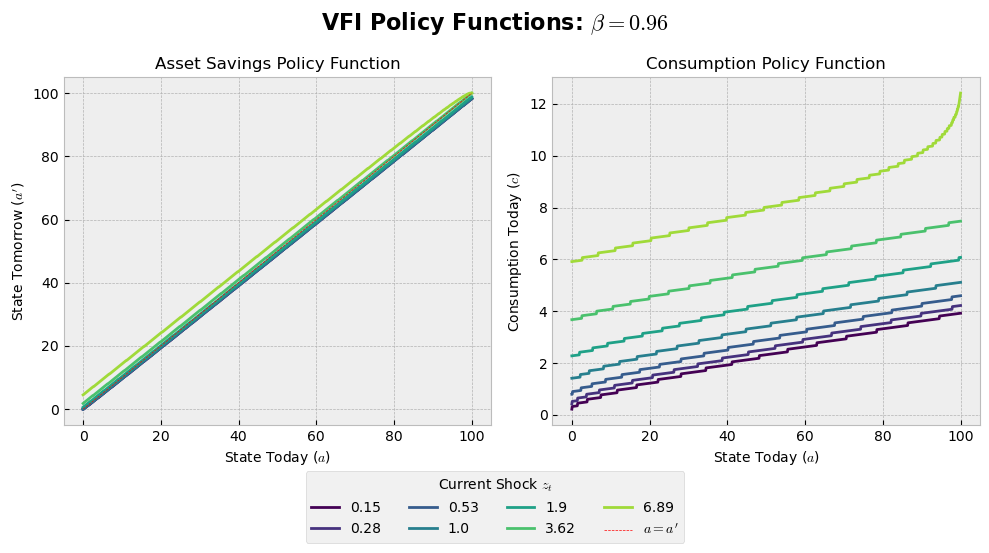

In [31]:
plot_policy(linear_state_grid,
            policy_a_vfi,
            policy_c_vfi,
            shock_space=np.around(state_grid_shock, 2),
            title=fr'VFI Policy Functions: $\beta = {beta}$')

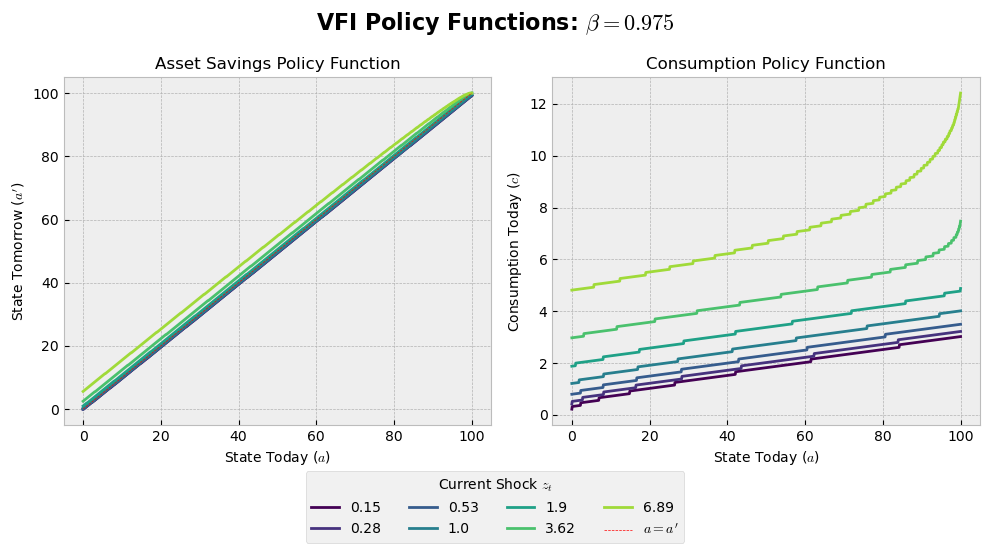

In [32]:
plot_policy(linear_state_grid,
            policy_a_vfi_alt,
            policy_c_vfi_alt,
            shock_space=np.around(state_grid_shock, 2),
            title=fr'VFI Policy Functions: $\beta = {beta_alt}$')

In [33]:
# Comparing policy functions for a given state across values of beta
## State value
state_for_plot = 1
state_for_plot_index = int(np.searchsorted(state_grid_shock, state_for_plot))

## Selecting values we will plot
policy_a_comparison_plot = np.array([policy_a_vfi[state_for_plot_index], policy_a_vfi_alt[state_for_plot_index]])
policy_c_comparison_plot = np.array([policy_c_vfi[state_for_plot_index], policy_c_vfi_alt[state_for_plot_index]])

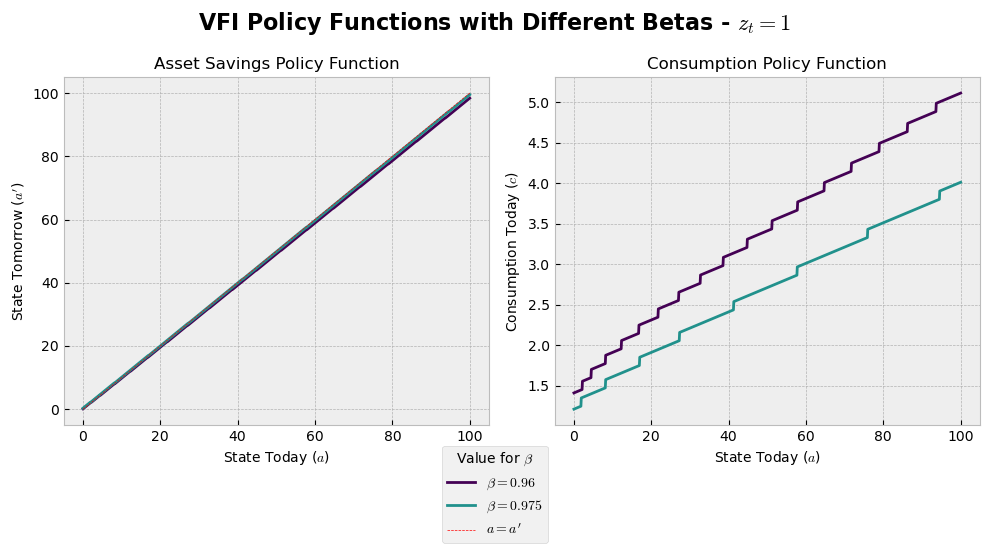

In [34]:
plot_policy(linear_state_grid,
            policy_a_comparison_plot,
            policy_c_comparison_plot,
            np.array([rf'$\beta = {beta}$', rf'$\beta = {beta_alt}$']),
            title=rf'VFI Policy Functions with Different Betas - $z_t = {state_for_plot}$',
            legend_title=rf"Value for $\beta$")

The higher the $\beta$, the more patient are agents.
Thus, they can accept a trade-off of lower consumption and more asset buying, which is what we see in the above graph: the consumption policy function of $\beta = .96$ is higher at all points than the one for $\beta = .975$.

# (f) EGM

## Envelope

We already defined the labor functions we will use.

We now have to define functions for our endogenous grid and for the envelope condition.

Recall that

$$
c = \left( \beta \mathbb{E}\left[ V_a(z', a') \mid z\right] \right)^{-\frac{1}{\sigma}} + \chi \frac{h^{1+\varphi}}{1+\varphi}
$$

by the FOC of the Bellman Equation and 

$$
V_a (z, a) = u_a(c, h) = \frac{\partial c}{\partial a} u_c(c, h) = (1 + r) \left(c - \chi \frac{h^{1+\varphi}}{1+\varphi} \right)^{-\sigma}
$$

by the Envelope Condition.
Furthermore, by definition,

$$
\mathbb{E}\left[ V_a(z', a') \mid z_i \right] = \sum_{j = 1}^{n_z} \pi_{ij} V_a (z_j', a'),
$$

where $\pi_{ij}$ are elements of the transition matrix.

In [35]:
def get_endog_consumption(EVa, policy_h, param_dict, tol=1e-6):
    # Parameters
    beta = param_dict['beta']
    sigma = param_dict['sigma']
    chi = param_dict['chi']
    varphi = param_dict['varphi']

    # Calculating marginal utility of consumption and consumption itself
    marg_utility_c = beta * EVa
    endog_c = marg_utility_c ** (-1 / sigma) + chi * (policy_h ** (1 + varphi) / (1 + varphi))

    return np.maximum(endog_c, tol)

In [36]:
def envelope_condition(r, c, h, param_dict):
    # Parameters
    sigma = param_dict['sigma']
    chi = param_dict['chi']
    varphi = param_dict['varphi']

    return (1 + r) * (c - chi * h**(1 + varphi) / (1 + varphi))**(-sigma)

## EGM

We now create the functions that implement the EGM.

As seen in Lecture 9, it is useful to make a change of variable to get a *cash-at-hand* interpretation.
In our case, recall that the budget constraint is

$$
c + a' = (1 + r) a + z h w
$$

and so we can define the cash at hand $Y$ as 

\begin{align*}
\text{Exogenous Grid:  } & Y(z, a) \coloneqq (1 + r)a + w \cdot z \cdot h(z, a) &&\\
\text{Endogenous Grid:  } & Y(z, a) \coloneqq c(z, a) + a'(z, a)
\end{align*}


where we already substituted the policy functions.

In [37]:
def EGM_step(Va, r_guess, transition_matrix, state_grid, shock_grid, param_dict, tol):
    """
    Function that makes one step of the EGM algorithm.

    Args:
        Va: partial derivative of the value function with respect to a, obtained with the envelope condition.
            This is a num_shocks x num_states matrix.
        r_guess: guess for market clearing interest rate on bonds
        transition_matrix: transition matrix of the Markov process associated with the shock
        state_grid: grid with the state values
        shock_grid: grid with the shock values
        param_dict: dictionary of parameters
        type_interp: type of interpolationg (string) to pass to scipy interp1d. 
            Main options are 'linear' or 'nearest'
    """

    # Dimensions
    num_shocks = shock_grid.shape[0]
    num_states = state_grid.shape[0]

    # Getting wage, policy labor (which doesn't depend on anything endogenous due to the form
    # of our utility function) and effective labor
    w = get_wage(r=r_guess, param_dict=param_dict)
    policy_h = get_policy_h(r=r_guess, z=shock_grid, param_dict=param_dict)
    effective_labor = get_effective_labor(r=r_guess, z=shock_grid, param_dict=param_dict)

    # w is a scalar, while policy_h and effective labor are num_shocks x 1 vectors (depend only
    # current shock, not on assets and consumption - thanks utility functional form)
    # We will need to make dimensions match, so we modify them a little bit
    policy_h = policy_h[:, np.newaxis]
    effective_labor = effective_labor[:, np.newaxis]

    # Calculating the expected value of Va by weighting by the transition matrix
    # Each row represent the expected value conditional on being in that state today
    EVa = transition_matrix @ Va

    # Calculating consumption
    endog_c = get_endog_consumption(EVa=EVa, policy_h=policy_h, param_dict=param_dict, tol=tol)

    # Calculating exogenous and endogenous grid of cash-at-hand (this are num_shocks x num_states matrices)
    exog_cash = (1 + r_guess) * state_grid + w * effective_labor
    endog_cash = endog_c + state_grid

    # Creating interpolation object and looping across states (endog_cash is state_dependent
    # and, thus, a matrix with first dimension being number of shocks)
    ## Skeleton
    policy_a_prime = np.zeros([num_shocks, num_states])

    ## Looping to fill
    for index_shock in range(num_shocks):
        # Interpolating
        policy_a_prime[index_shock] = np.interp(exog_cash[index_shock], endog_cash[index_shock], state_grid)

        # Enforcing borrowing constraint
        policy_a_prime[index_shock] = np.maximum(policy_a_prime[index_shock], state_grid[0])

    # Getting policy consumption using the budget constraint, respecting that consumption can't be negative
    policy_c = np.maximum(exog_cash - policy_a_prime, tol)

    # Getting values for the partial derivative of the value function in the next period
    ## These are given by the envelope condition
    Va_prime = envelope_condition(r=r_guess, c=policy_c, h=policy_h, param_dict=param_dict)

    # Returning values for the next iteration
    return Va_prime, policy_a_prime, policy_c, policy_h

In [38]:
def EGM_ss(r_guess, transition_matrix, state_grid, shock_grid, 
           param_dict, max_iter=1000, tol=1e-6):
    """
    Function that iterates through EGM steps until convergence to steady-state.

    Args:
        Va: partial derivative of the value function with respect to a, obtained with the envelope condition.
            This is a num_shocks x num_states matrix.
        r_guess: guess for market clearing interest rate on bonds
        transition_matrix: transition matrix of the Markov process associated with the shock
        state_grid: grid with the state values
        shock_grid: grid with the shock values
        param_dict: dictionary of parameters
        type_interp: type of interpolationg (string) to pass to scipy interp1d. 
            Main options are 'linear' or 'nearest'
        max_iter: maximum number of iterations
        tol: tolerance level
    """

    # Initial values: see function EGM_step for details
    w = get_wage(r=r_guess, param_dict=param_dict)
    policy_h = get_policy_h(r=r_guess, z=shock_grid, param_dict=param_dict)
    effective_labor = get_effective_labor(r=r_guess, z=shock_grid, param_dict=param_dict)

    # w is a scalar, while policy_h and effective labor are num_shocks x 1 vectors (depend only
    # current shock, not on assets and consumption - thanks utility functional form)
    # We will need to make dimensions match, so we modify them a little bit
    policy_h = policy_h[:, np.newaxis]
    effective_labor = effective_labor[:, np.newaxis]
    
    # We need an initial guess for Va: will follow the slides and say consumption is just the log of income.
    # Since the borrowing constraint is 0, no need to worry about negative values 
    ## Cash and consumption
    exog_cash = (1 + r_guess) * state_grid + w * effective_labor
    initial_c = np.fmax(np.log(exog_cash), tol) # to handle NaNs eventually produced by np.log(negative)

    ## Getting the partial derivative matrices by the envelope condition
    Va = envelope_condition(r=r_guess, c=initial_c, h=policy_h, param_dict=param_dict)

    # Skeleton for policy asset allocation
    policy_a_prime = exog_cash - initial_c

    # Iterating until convergence
    for num_iter in range(max_iter):
        # Calculating the variables for this step
        Va, policy_a_prime_new, policy_c, policy_h = \
            EGM_step(
                Va=Va,
                r_guess=r_guess,
                transition_matrix=transition_matrix,
                state_grid=state_grid,
                shock_grid=shock_grid,
                param_dict=param_dict,
                tol=tol
            )
        
        # Checking if we found the fixed point using the sup norm FOR EACH shock
        # That is, we want the loop to stop when all conditions are satisfied
        if np.max(np.abs(policy_a_prime_new - policy_a_prime)) < tol:
            break
        else:
            policy_a_prime = policy_a_prime_new.copy()
    
    # Assessing convergence
    if num_iter >= max_iter - 1:
        print(f"EGM did not converge in {max_iter} iterations.")
    
    # Returning
    return policy_a_prime_new, policy_c, policy_h, num_iter

In [39]:
# Calculating policy functions with the EGM
t0 = time.time()
policy_a_egm, policy_c_egm, policy_h_egm, num_iter_egm = \
    EGM_ss(
        r_guess=r_value,
        transition_matrix=transition_matrix,
        state_grid=linear_state_grid,
        shock_grid=state_grid_shock,
        param_dict=param_dict
    )

time_egm = time.time() - t0

In [40]:
# Calculating policy functions with the EGM with higher beta
t0 = time.time()
policy_a_egm_alt, policy_c_egm_alt, policy_h_egm_alt, num_iter_egm_alt = \
    EGM_ss(
        r_guess=r_value,
        transition_matrix=transition_matrix,
        state_grid=linear_state_grid,
        shock_grid=state_grid_shock,
        param_dict=param_dict_alt
    )

time_egm_alt = time.time() - t0

In [41]:
# Print times
print(f"EGM with beta = {beta} took {round(time_egm, 1)} seconds.")
print(f"EGM with beta = {beta_alt} took {round(time_egm_alt, 1)} seconds.")

EGM with beta = 0.96 took 1.0 seconds.
EGM with beta = 0.975 took 0.8 seconds.


We still see a decrease in performance with higher $\beta$ in the EGM, but nowhere near as much as in the VFI (in absolute terms).

## Policy Functions

### Different $\beta$

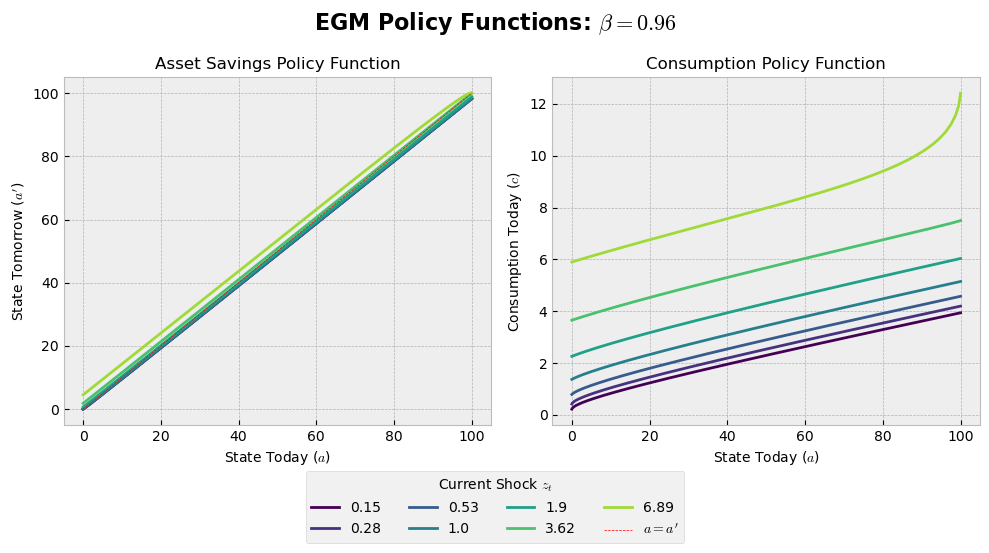

In [42]:
plot_policy(linear_state_grid,
            policy_a_egm,
            policy_c_egm,
            shock_space=np.around(state_grid_shock, 2),
            title=fr'EGM Policy Functions: $\beta = {beta}$')

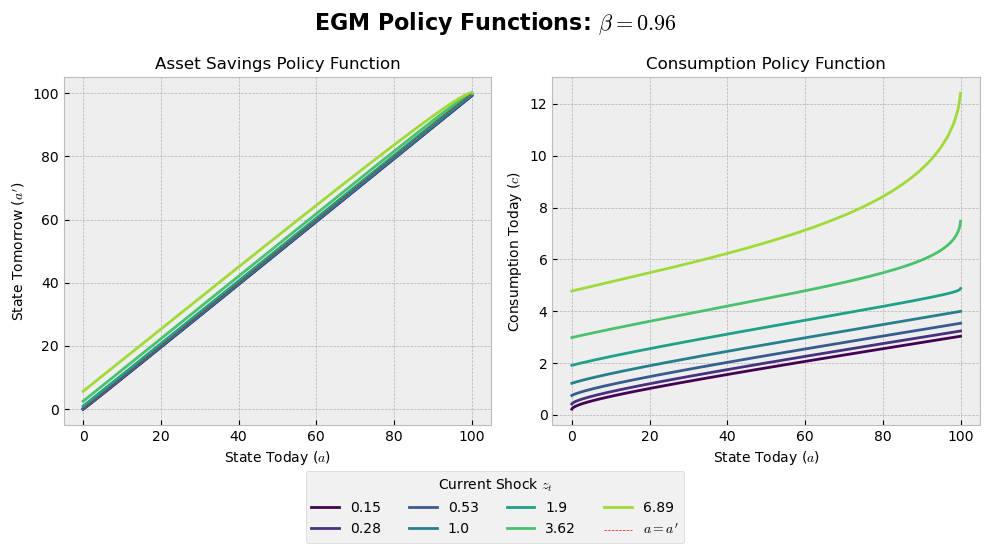

In [43]:
plot_policy(linear_state_grid,
            policy_a_egm_alt,
            policy_c_egm_alt,
            shock_space=np.around(state_grid_shock, 2),
            title=fr'EGM Policy Functions: $\beta = {beta}$')

### Comparison with VFI

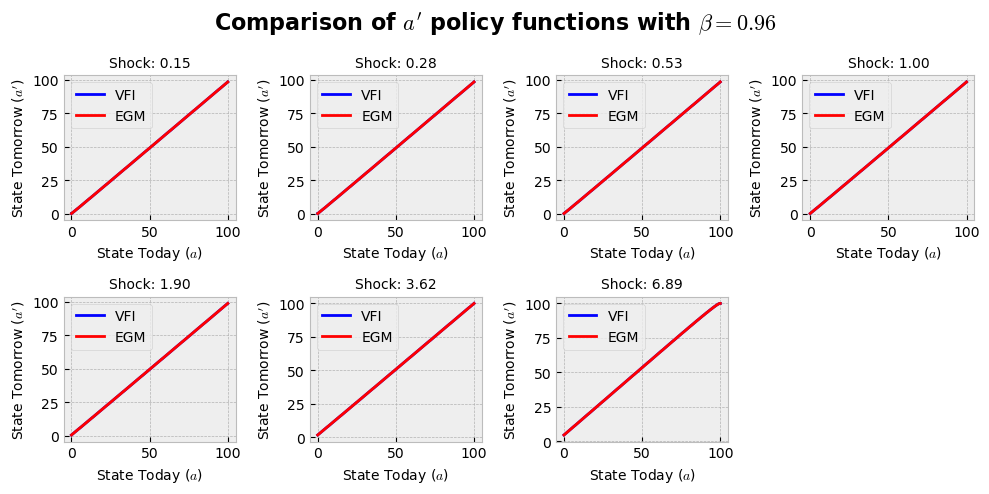

In [44]:
# Parameters for plot
n_rows_comparison_plot = 2

# Create the figure and a grid of subplots
fig, axs = plt.subplots(nrows=2, ncols=int(num_shocks / 2) + 1, figsize=(10, 5))
fig.suptitle(fr"Comparison of $a'$ policy functions with $\beta = {beta}$", fontsize=16, fontweight='bold')

# Flatten the axs array to easily loop through each subplot
axs = axs.flatten()

# Loop through each plot and populate the data
for n in range(num_shocks):
    ax = axs[n]
    
    # Plot both policies for the current state
    ax.plot(linear_state_grid, policy_a_vfi[n, :], label='VFI', color='b')
    ax.plot(linear_state_grid, policy_a_egm[n, :], label='EGM', color='r')
    
    # Set the title based on state_grid_productivity
    ax.set_title(f'Shock: {state_grid_shock[n]:.2f}', fontsize=10)
    
    # Add labels and legend
    ax.set_xlabel(r"State Today ($a$)", fontsize=10)
    ax.set_ylabel(r"State Tomorrow ($a'$)", fontsize=10)
    ax.legend()

# Hide any unused subplots if num_plots is less than total grid slots
for idx in range(num_shocks, len(axs)):
    fig.delaxes(axs[idx])

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

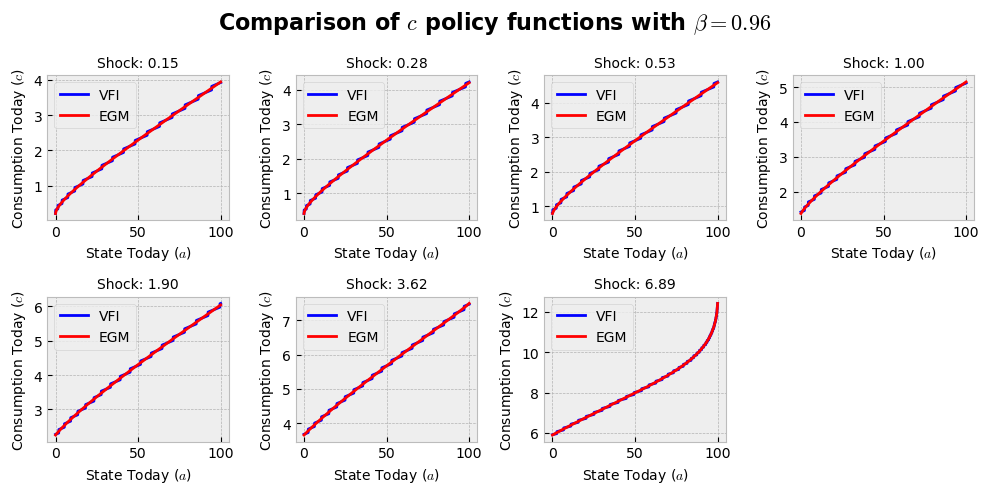

In [45]:
# Parameters for plot
n_rows_comparison_plot = 2

# Create the figure and a grid of subplots
fig, axs = plt.subplots(nrows=2, ncols=int(num_shocks / 2) + 1, figsize=(10, 5))
fig.suptitle(fr"Comparison of $c$ policy functions with $\beta = {beta}$", fontsize=16, fontweight='bold')

# Flatten the axs array to easily loop through each subplot
axs = axs.flatten()

# Loop through each plot and populate the data
for n in range(num_shocks):
    ax = axs[n]
    
    # Plot both policies for the current state
    ax.plot(linear_state_grid, policy_c_vfi[n, :], label='VFI', color='b')
    ax.plot(linear_state_grid, policy_c_egm[n, :], label='EGM', color='r')
    
    # Set the title based on state_grid_productivity
    ax.set_title(f'Shock: {state_grid_shock[n]:.2f}', fontsize=10)
    
    # Add labels and legend
    ax.set_xlabel(r"State Today ($a$)", fontsize=10)
    ax.set_ylabel(r"Consumption Today ($c$)", fontsize=10)
    ax.legend()

# Hide any unused subplots if num_plots is less than total grid slots
for idx in range(num_shocks, len(axs)):
    fig.delaxes(axs[idx])

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

The asset savings policy functions are identical across both methods.

However, the consumption policy function has the usual kinks in the VFI, being smoother in the EGM.

# (g) Equilibrium

Moving forward, we will only use the EGM method.

The above solves steps 1-4 in Slide 21 of Lecture 7 using the EGM method, and it would be the end of it if we were in a model with no heterogeneity, such as the RBC.

We still need to solve steps 5-7, which require finding the stationary distribution of assets $\lambda (z, a)$ and the aggregate capital and labour supplies.

Under the *monotonic mixing condition*, we know that such a distribution exists and is unique.

Note that, even if aggregates are constant, individual-specific variables are not: the distribution is the same, but the individuals occupying each position are not.
Agents jump frequently around the distribution, but in such a way that aggregates don't change (in the stationary distribution $\lambda(z, a)$).

## Stationary Distribution

To find these objects, we will use the non-stochastic simulation proposed by [Young (JEDC 2010)](https://ideas.repec.org/a/eee/dyncon/v34y2010i1p36-41.html).

[Tomás Martinez's Notes](https://tomasrm.github.io/teaching/quantmacro/) are a good reference (specially "Aiyagari - Computational Details"), as well as Pedro Costa's codes from 2023.

As we are using a linear interpolation method, the policy function is usually off-grid.
We allocate some agents in the grid below and some in the grid above using a "lottery" in a way that preserves the aggregate mass of assets:

$$
a'(z, a) = p a_{\eta} + (1-p)a_{\eta + 1},
$$

where $a_{\eta}$ is the grid point just below $a'$ and $a_{\eta + 1}$ is the point just above it.
We then associate a probability $p$ of $a'$ being $a_{\eta}$ and $1-p$ of it being $a_{\eta + 1}$.

Afterwards, we can just iterate forward on the distribution until it converges.

In [46]:
def find_indexes(policy, state_grid):
    # Finding the indexes of points just below the policy function
    # See https://numpy.org/doc/stable/reference/generated/numpy.searchsorted.html
    eta_matrix = np.searchsorted(state_grid, policy) - 1

    # Calculating probability that the policy falls in that interval
    p_matrix = (state_grid[eta_matrix + 1] - policy) / (state_grid[eta_matrix + 1] - state_grid[eta_matrix])

    # Returning
    return eta_matrix, p_matrix

We now can iterate to find the stationary distribution.

In [47]:
@njit # decorator to make things faster
def stationary_distribution_step(asset_distribution, transition_matrix,
                                 indexes_matrix, probability_matrix):
    # Dimensions
    num_shocks = indexes_matrix.shape[0]
    num_states = indexes_matrix.shape[1]

    # Skeleton of new asset distribution
    # new_asset_distribution = np.zeros([num_shocks, num_states]) # throws an error with numba
    new_asset_distribution = np.zeros_like(asset_distribution)

    # Looping to fill using the probability matrix
    for shock_index in range(num_shocks):
        for state_index in range(num_states):
            # Sending measure p of agents to the lower point of new distribution
            new_asset_distribution[shock_index, indexes_matrix[shock_index, state_index]] += \
                probability_matrix[shock_index, state_index] * asset_distribution[shock_index, state_index]
            
            # Sending measure 1-p of agents to the upper point of new distribution
            new_asset_distribution[shock_index, indexes_matrix[shock_index, state_index] + 1] += \
                (1 - probability_matrix[shock_index, state_index]) * asset_distribution[shock_index, state_index]
    
    # Applying the markov chain of the labour process
    new_asset_distribution = new_asset_distribution.T @ transition_matrix
    new_asset_distribution = new_asset_distribution.T
    # new_asset_distribution = transition_matrix.T @ new_asset_distribution

    return new_asset_distribution

In [48]:
def get_stationary_distribution(policy_a, state_grid, transition_matrix,
                                tol=1e-12, max_iter=10_000, print_convervence=True):
    # Dimensions
    num_shocks = transition_matrix.shape[0]
    num_states = state_grid.shape[0]

    # Getting indexes and probabilities
    indexes_matrix, probability_matrix = find_indexes(policy_a, state_grid)

    # Initial guess for the asset distribution (equality)
    asset_distribution = np.ones([num_shocks, num_states]) / (num_shocks * num_states)

    # Iterating
    for num_iter in range(max_iter):
        # New distribution
        asset_distribution_new = stationary_distribution_step(
            asset_distribution=asset_distribution,
            transition_matrix=transition_matrix,
            indexes_matrix=indexes_matrix,
            probability_matrix=probability_matrix
        )

        # Assessing convergence
        if np.max(np.abs(asset_distribution_new - asset_distribution)) < tol:
            break
        else:
            asset_distribution = asset_distribution_new.copy()
    
    # Assessing convergence
    if print_convervence is True:
        if num_iter == max_iter - 1:
            print(f"Stationary distribution did not converge in {max_iter} iterations with tolerance {tol}.")
        else:
            print(f"Stationary distribution converged in {num_iter} iterations.")


    return asset_distribution_new

## Market Clearing

In [49]:
def get_aggregate(stationary_distribution, policy_matrix):
    """
    The stationary distribution is a num_shocks x num_states grid,
    while policy_matrix is a num_shocks x num_states matrix as well.
    """

    # Getting dimensions
    num_shocks = policy_matrix.shape[0]
    num_states = policy_matrix.shape[1]

    # Looping across shocks to calculate aggregates
    ## Initializing
    aggregate = 0

    ## Looping
    for index_shock in range(num_shocks):
        aggregate += np.dot(policy_matrix[index_shock], stationary_distribution[index_shock])

    # Returning
    return aggregate

We now compute the aggregate capital-to-labor ratio using the firm's problem.
This is given by the FOC w.r.t. capital, which is

$$
\tilde{r} = \alpha \left( \frac{K}{H} \right)^{\alpha - 1}
$$

Using arbitrage, $\tilde{r} = r + \delta$. Then,

$$
\frac{K}{H} = \left( \frac{\alpha}{r + \delta} \right)^\frac{1}{1 - \alpha}
$$

In [50]:
def aggregate_demand(r, param_dict):
    # Parameters
    delta = param_dict['delta']
    alpha = param_dict['alpha']

    # Returning the K/H ratio
    return (alpha / (r + delta))**(1 / (1 - alpha))

## Solution - Putting it All Together

In [51]:
def aggregate_supply(r_guess,
                     transition_matrix, stationary_shock_distribution,
                     state_grid, shock_grid, param_dict, 
                     max_iter_hh=10_000, tol_hh=1e-6,
                     max_iter_stat_dist=10_000, tol_stat_dist=1e-12, print_convergence=True):
    """
    Solves the supply side of the Aiyagari model, solving the households decision then
    computing distribution. For variable details, see descriptions of other functions.
    """

    # Dimensions
    num_states = state_grid.shape[0]
    num_shocks = shock_grid.shape[0]
    
    # 1. Solving the households' problem
    policy_a_prime, policy_c, policy_h, num_iter = EGM_ss(
        r_guess=r_guess,
        transition_matrix=transition_matrix,
        state_grid=state_grid,
        shock_grid=shock_grid,
        param_dict=param_dict,
        max_iter=max_iter_hh,
        tol=tol_hh
    )

    # 2. Computing the stationary distribution
    stationary_distribution = get_stationary_distribution(
        policy_a=policy_a_prime,
        state_grid=state_grid,
        transition_matrix=transition_matrix,
        max_iter=max_iter_stat_dist,
        tol=tol_stat_dist,
        print_convervence=print_convergence
    )

    # 3. Compute aggregates
    ## Consumption
    aggregate_C = get_aggregate(stationary_distribution, policy_c)

    ## Assets tomorrow = capital
    # aggregate_K = get_aggregate(stationary_distribution, policy_a_prime)
    aggregate_K = get_aggregate(stationary_distribution, np.tile(state_grid, (num_shocks, 1)))

    ## Labor supply: recall that it doesn't depend on assets, so we use the stationary distribution of shocks
    aggregate_H = get_aggregate(stationary_shock_distribution, policy_h)[0]

    ## Alternative way: matches the slides, but does not produce aggregate_H == 1 (and some results are weird)
    ## Instead of using a', we use a to get the aggregate capital stock and we multiply policy_h by the shocks
    ## to get a measure of "effective labor"
    # aggregate_H = get_aggregate(stationary_shock_distribution, policy_h * shock_grid)[0]

    ## Output
    aggregate_Y = (aggregate_K ** param_dict['alpha']) * (aggregate_H ** (1 - param_dict['alpha']))

    ## We will assess convergence using capital to labor ratio
    K_H_ratio_supply = aggregate_K / aggregate_H

    # Returning the results as a dictionary (too crowed otherwise)
    return dict(r=r_guess,
                policy_a_prime=policy_a_prime, 
                policy_c=policy_c,
                policy_h=policy_h, 
                stationary_distribution=stationary_distribution,
                state_grid=state_grid,
                shock_grid=shock_grid,
                stationary_shock_distribution=stationary_shock_distribution, 
                w=get_wage(r_guess, param_dict),
                aggregate_C=aggregate_C, 
                aggregate_K=aggregate_K, 
                aggregate_H=aggregate_H, 
                aggregate_Y=aggregate_Y,
                K_H_ratio=K_H_ratio_supply)

In [52]:
def excess_demand_capital(r_guess, transition_matrix, stationary_shock_distribution,
                          state_grid, shock_grid, param_dict, 
                          max_iter_hh=10_000, tol_hh=1e-6,
                          max_iter_stat_dist=10_000, tol_stat_dist=1e-12, print_convergence=True):
    # Aggregate supply
    supply_solution = aggregate_supply(
        r_guess=r_guess,
        transition_matrix=transition_matrix,
        stationary_shock_distribution=stationary_shock_distribution,
        state_grid=state_grid,
        shock_grid=shock_grid,
        param_dict=param_dict,
        max_iter_hh=max_iter_hh,
        tol_hh=tol_hh,
        max_iter_stat_dist=max_iter_stat_dist,
        tol_stat_dist=tol_stat_dist,
        print_convergence=print_convergence
    )
    K_H_ratio_supply = supply_solution['K_H_ratio']

    # Aggregate demand
    K_H_ratio_demand = aggregate_demand(r_guess, param_dict)

    # Printing for debugging
    # print(f"Guess for r: {np.around(r_guess, 4)}")
    # print(f"Excess demand: {np.around(K_H_ratio_demand - K_H_ratio_supply, 4)}")

    return K_H_ratio_demand - K_H_ratio_supply

In [53]:
# Initial guess
r_lb = -param_dict['delta']
r_ub = 1 / param_dict['beta'] - 1
r_guess = (r_lb + r_ub) / 2

In [54]:
# Solving for r using f_solve, which uses Powell's Hybrid Method
aiyagari_opt = fsolve(
    func=lambda r: excess_demand_capital(
        r_guess=r,
        transition_matrix=transition_matrix,
        stationary_shock_distribution=stationary_dist_shocks,
        state_grid=linear_state_grid,
        shock_grid=state_grid_shock,
        param_dict=param_dict
    ),
    x0=r_guess,
    full_output=True
)

Stationary distribution converged in 583 iterations.
Stationary distribution converged in 583 iterations.
Stationary distribution converged in 583 iterations.
Stationary distribution converged in 583 iterations.
Stationary distribution converged in 661 iterations.
Stationary distribution converged in 751 iterations.
Stationary distribution converged in 735 iterations.
Stationary distribution converged in 736 iterations.
Stationary distribution converged in 736 iterations.
Stationary distribution converged in 736 iterations.
Stationary distribution converged in 736 iterations.


In [55]:
# Printing solution
r_market_clearing = aiyagari_opt[0][0]
num_iter_market = aiyagari_opt[1]['nfev']

print(f"Market clearing r: {round(100 * r_market_clearing, 4)}%.")
print(f"Iterations of fsolve: {num_iter_market}.")

Market clearing r: 1.2516%.
Iterations of fsolve: 9.


In [56]:
# Getting steady-state values
aiyagari_solution_dict = aggregate_supply(
    r_guess=r_market_clearing,
    transition_matrix=transition_matrix,
    stationary_shock_distribution=stationary_dist_shocks,
    state_grid=linear_state_grid,
    shock_grid=state_grid_shock,
    param_dict=param_dict
)

Stationary distribution converged in 736 iterations.


In [57]:
# Rechecking market clearing
print(f"Excess demand in K/H: {round(aiyagari_solution_dict['K_H_ratio'] - aggregate_demand(r_market_clearing, param_dict), 6)}")

Excess demand in K/H: -0.0


In [58]:
# Wage
print(f"Wage: {round(aiyagari_solution_dict['w'], 2)}")

Wage: 1.59


## Policy Functions

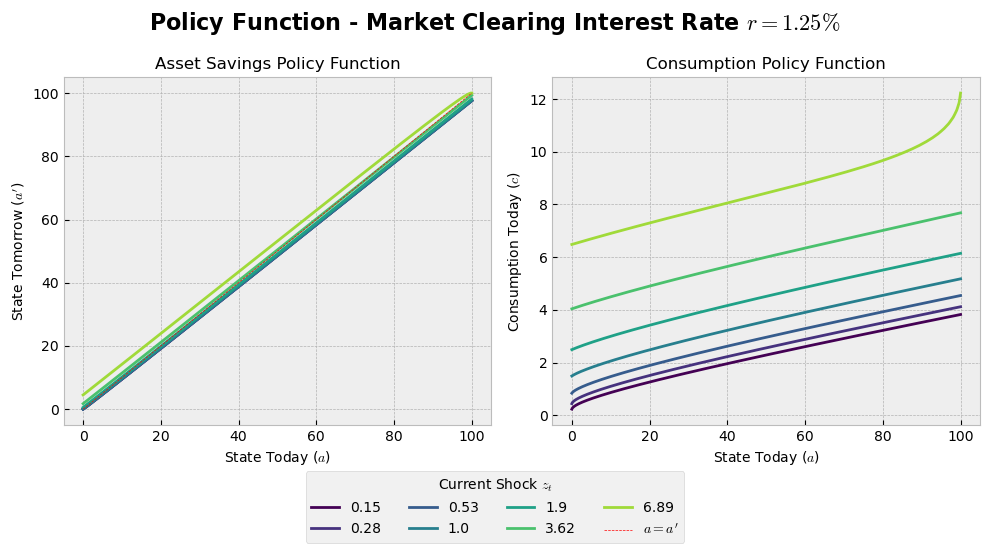

In [59]:
plot_policy(linear_state_grid,
            aiyagari_solution_dict['policy_a_prime'],
            aiyagari_solution_dict['policy_c'],
            shock_space=np.around(state_grid_shock, 2),
            title=fr'Policy Function - Market Clearing Interest Rate $r = {round(100 * r_market_clearing, 2)}\%$')

## Supply and Demand Graph


We will recreate the figure of asset demand x supply as (inverse) functions of the interest rate.

In [60]:
# Defining grid of r
num_points_supply_demand = 30
r_grid = np.linspace(r_lb + 0.005, r_ub - 0.005, num_points_supply_demand)

# Skeletons of capital to labor supply and demand
capital_labor_demand_grid = np.zeros([num_points_supply_demand])
capital_labor_supply_grid = np.zeros([num_points_supply_demand])

# Iterating
for index, r in enumerate(r_grid):
    # Demand of firms
    capital_labor_demand_grid[index] = aggregate_demand(r, param_dict)

    # Supply of households
    aiyagari_solution_dict_supply_demand = aggregate_supply(
        r_guess=r,
        transition_matrix=transition_matrix,
        stationary_shock_distribution=stationary_dist_shocks,
        state_grid=linear_state_grid,
        shock_grid=state_grid_shock,
        param_dict=param_dict,
        print_convergence=False
    )

    capital_labor_supply_grid[index] = aiyagari_solution_dict_supply_demand['K_H_ratio']

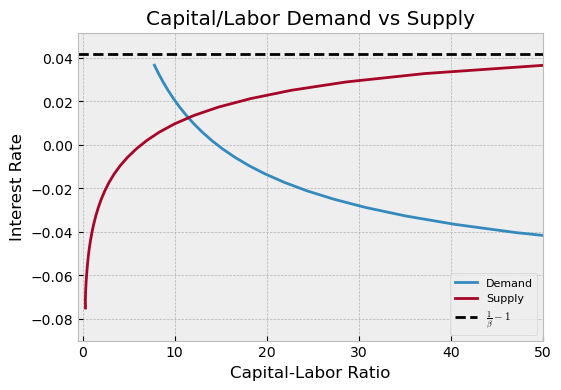

In [61]:
# Plotting
plt.figure(figsize=(6, 4))

plt.plot(capital_labor_demand_grid, r_grid, label='Demand')
plt.plot(capital_labor_supply_grid, r_grid, label='Supply')
plt.axhline(y=r_ub, color='k', linestyle='--', label=r'$\frac{1}{\beta} - 1$')

# Adding labels and title
plt.title('Capital/Labor Demand vs Supply')
plt.xlabel('Capital-Labor Ratio')
plt.ylabel('Interest Rate')
plt.legend(loc='best', fontsize=8)

# Limiting the axis
plt.xlim(-0.5, 50)
plt.ylim(r_lb - 0.01, r_ub + 0.01)

# Show the plot
plt.show()

## Investment Rate and Capital-Output Ratio

Recall that

$$
K_{t+1} = (1 - \delta) K_t + I_t
$$

At the steady-state, $K_{t} = K_{t+1} = K$, so that

$$
I_t = \delta K
$$

i.e., investment is just enough to replenish capital depreciation.

In [62]:
# Capital is equal to bond stock due to market clearing
aggregate_K = aiyagari_solution_dict['aggregate_K']

# Output is given by Cobb-Douglas
aggregate_H = aiyagari_solution_dict['aggregate_H']
aggregate_Y = (aggregate_K ** alpha) * (aggregate_H ** (1 - alpha))

# Getting consumption
aggregate_C = aiyagari_solution_dict['aggregate_C']

# Printing results
print(f"Capital: {round(aggregate_K, 2)}")
print(f"Labor: {round(aggregate_H, 2)}")
print(f"Output: {round(aggregate_Y, 2)}")

print(f"\nCapital-to-Output Ratio: {round(aggregate_K / aggregate_Y, 2)}")
print(f"Capital-to-Labor Ratio: {round(aggregate_K / aggregate_H, 2)}")

print(f"\nConsumption: {round(aggregate_C, 2)}")
print(f"Gross Investment: {round(delta * aggregate_K, 2)}")
print(f"Investment Rate: {round(100* delta * aggregate_K / aggregate_Y, 1)}%")

Capital: 11.47
Labor: 1.0
Output: 2.65

Capital-to-Output Ratio: 4.32
Capital-to-Labor Ratio: 11.47

Consumption: 2.3
Gross Investment: 0.92
Investment Rate: 34.6%


## Wealth Distribution

#### First Way

In [63]:
# Getting stationary distribution
## This is a num_shocks x num_states matrix: it tells us the proportion of agents
## that are in shock i and have assets j in the statioary equilibrium
stationary_distribution_matrix = aiyagari_solution_dict['stationary_distribution']

# Checking sum
np.around(np.sum(stationary_distribution_matrix), 6)

1.0

In [ ]:
# To get the unconditional distribution, we first must transform the above into
# conditional probabilities, so that each row sums to 1
## Skeleton
stationary_conditional_distribution_matrix = stationary_distribution_matrix.copy()

## Looping
for index_shock in range(num_shocks):
    for index_state in range(num_states):
        stationary_conditional_distribution_matrix[index_shock, index_state] = \
            stationary_distribution_matrix[index_shock, index_state] \
                / np.sum(stationary_distribution_matrix[index_shock])

# Checking sum across rows
np.around(np.sum(stationary_conditional_distribution_matrix, axis=1), 6)

array([1., 1., 1., 1., 1., 1., 1.])

In [65]:
# Calculating the probability mass function at each grid point: we multiply the above matrix
# by the stationary distribution of shocks to get the actual unconditional
# distribution of assets in the economy in the stationary equilibrium
stationary_pmf = (stationary_dist_shocks @ stationary_conditional_distribution_matrix)

print(f"Shape: {stationary_pmf.shape}")
print(f"Sum: {np.around(np.sum(stationary_pmf), 6)}")

Shape: (1000,)
Sum: 1.0


In [66]:
# Getting cumulative distribution
stationary_cdf = np.cumsum(stationary_pmf)

We now define some functions to get some aspects of the distribution.

In [67]:
def get_values_from_quantiles(state_grid, stationary_cdf, 
                              quantiles=[.01, .05, .1, .5, .9, .95, .99]):
    """
    Given quantiles, return the corresponding values from linear_state_grid.
    """

    return np.interp(quantiles, stationary_cdf, state_grid)

In [68]:
def get_lorenz_curve(state_grid, stationary_pmf):
    """ 
    Calculates the Lorenz Curve of state grid. Intervals for x-axis are
    the same as state_grid.
    Importantly, it assumes state_grid and stationary_pmf are sorted
    by ascending value of state_grid.
    """

    # Calculating Lorenz curve
    lorenz_curve = np.cumsum(state_grid * stationary_pmf)

    # Normalizing
    lorenz_curve_normalized = lorenz_curve / lorenz_curve[-1]

    return lorenz_curve, lorenz_curve_normalized

In [69]:
def get_gini(lorenz_curve, stationary_cdf):
    """ 
    Calculates the Gini coefficient of the distribution associated with lorenz_curve.
    Importantly, it assumes stationary_cdf is sorted by ascending value of state_grid.
    """

    # Normalizing the Lorenz curve
    lorenz_curve_normalized = lorenz_curve / lorenz_curve[-1]

    # Gini is 1 - twice the area under the Lorenz curve
    gini = 1 - 2 * np.trapz(lorenz_curve_normalized, stationary_cdf)

    return gini

In [ ]:
# Quantile values
quantiles = [.01, .05, .1, .5, .9, .95, .99]
quantile_asset_values = get_values_from_quantiles(
    state_grid=linear_state_grid,
    stationary_cdf=stationary_cdf,
    quantiles=quantiles
)

# Printing
for index, quantile in enumerate(quantiles):
    print(f"{int(100 * quantile)}% of Asset Distribution: {round(quantile_asset_values[index], 2)}")

1% of Asset Distribution: 0.0
5% of Asset Distribution: 0.0
10% of Asset Distribution: 0.0
50% of Asset Distribution: 3.82
90% of Asset Distribution: 34.19
95% of Asset Distribution: 49.89
99% of Asset Distribution: 88.9


In [71]:
# Calculating gini
lorenz_curve, lorenz_curve_norm = get_lorenz_curve(state_grid=linear_state_grid, stationary_pmf=stationary_pmf)
gini = get_gini(lorenz_curve=lorenz_curve, stationary_cdf=stationary_cdf)

print(f"Gini of Wealth: {round(gini, 3)}")

Gini of Wealth: 0.692


With the Lorenz Curve, we can see the share of wealth held by each quantile of the distribution.

In [72]:
# Getting values using our interpolation function
share_asset_values = get_values_from_quantiles(
    state_grid=lorenz_curve_norm,
    stationary_cdf=linear_state_grid,
    quantiles=quantile_asset_values
)

# Printing
for index, quantile in enumerate(quantiles):
    print(f"Share of wealth at the {int(100 * quantile)}% of Asset Distribution: {round(100 * share_asset_values[index], 1)}%")

Share of wealth at the 1% of Asset Distribution: 0.0%
Share of wealth at the 5% of Asset Distribution: 0.0%
Share of wealth at the 10% of Asset Distribution: 0.0%
Share of wealth at the 50% of Asset Distribution: 4.0%
Share of wealth at the 90% of Asset Distribution: 51.0%
Share of wealth at the 95% of Asset Distribution: 69.0%
Share of wealth at the 99% of Asset Distribution: 91.6%


In [73]:
def plot_cdf_and_lorenz(state_grid, lorenz_curve, lorenz_curve_norm, stationary_cdf, variable):
    """
    Plot the CDF and the Lorenz Curves of the distribution on a 1x3 grid.
    """

    # Create the figure and subplots
    fig, axes = plt.subplots(1, 3, figsize=(10, 5))
    plt.suptitle(f"{variable} Distribution", fontsize=16, fontweight='bold')

    # Plot CDF
    axes[0].plot(state_grid, stationary_cdf, color='blue', label='CDF')
    axes[0].set_title('CDF')
    axes[0].set_xlabel(f"{variable}")
    axes[0].set_ylabel(f'CDF of {variable}')
    axes[0].grid(True)
    
    # Plot Lorenz curve
    axes[1].plot(stationary_cdf, lorenz_curve, 
                 color='red', label='Lorenz Curve')
    axes[1].plot([0, 1], [state_grid[0], lorenz_curve[-1]], 
                 color='black', linestyle='--', label='Equality Line')
    axes[1].set_title('Lorenz Curve')
    axes[1].set_xlabel('Cumulative Share of Population')
    axes[1].set_ylabel(f'Cumulative {variable}')
    axes[1].legend(fontsize=8)

    # Plot Normalized Lorenz curve
    axes[2].plot(stationary_cdf, lorenz_curve_norm, 
                 color='green', label='Normalized Lorenz Curve')
    axes[2].plot([0, 1], [0, 1], 
                 color='black', linestyle='--', label='Equality Line')
    axes[2].set_title('Normalized Lorenz Curve')
    axes[2].set_xlabel('Cumulative Share of Population')
    axes[2].set_ylabel(f'Cumulative Share of {variable}')
    axes[2].legend(fontsize=8)
    
    # Show the plot
    plt.tight_layout()
    plt.show()

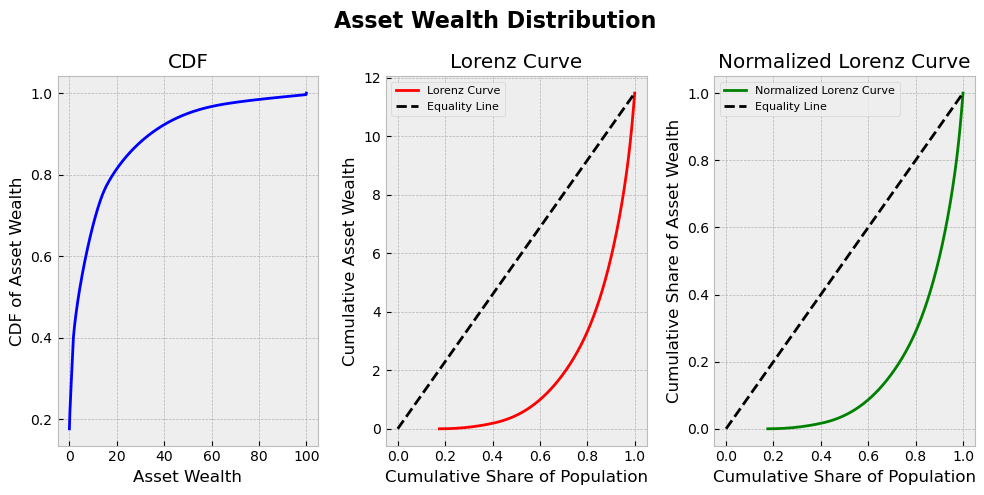

In [74]:
plot_cdf_and_lorenz(
    state_grid=linear_state_grid,
    lorenz_curve=lorenz_curve,
    lorenz_curve_norm=lorenz_curve_norm,
    stationary_cdf=stationary_cdf,
    variable='Asset Wealth'
)

Two things from the plot: there is a big mass of agents at the debt limit (as expected).
Furthermore, the wealth distribution is highly concentrated.

In [ ]:
# Fraction of credit constrained households
print(f"Share of credit-constrained households: {round(100 * stationary_pmf[0], 2)}%")

Share of credit-constrained households: 17.6%


We can also plot the distribution conditional on each $z$.

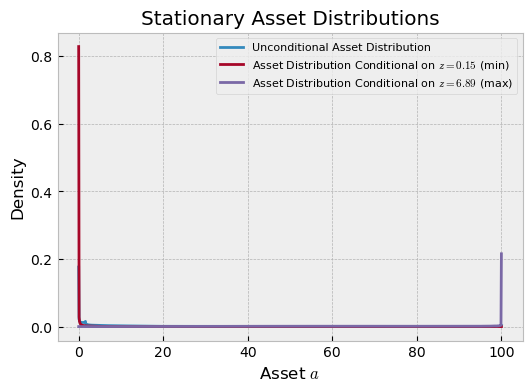

In [76]:
# Plotting the distribution of the aggregate and conditional on being in the lower
# and higher assey value
plt.figure(figsize=(6, 4))

plt.plot(linear_state_grid, stationary_pmf, 
         label='Unconditional Asset Distribution')

plt.plot(linear_state_grid, stationary_conditional_distribution_matrix[0, :], 
         label=fr'Asset Distribution Conditional on $z = {round(state_grid_shock[0], 2)}$ (min)')

plt.plot(linear_state_grid, stationary_conditional_distribution_matrix[-1, :], 
         label=fr'Asset Distribution Conditional on $z = {round(state_grid_shock[-1], 2)}$ (max)')

# Adding labels and title
plt.title('Stationary Asset Distributions')
plt.xlabel(r'Asset $a$')
plt.ylabel('Density')
plt.legend(loc='best', fontsize=8)

# Show the plot
plt.show()

We can see that those with the lowest labor productivity are those that are more credit constrained, while those with higher productivity are constrained by the upper ground of our grid.


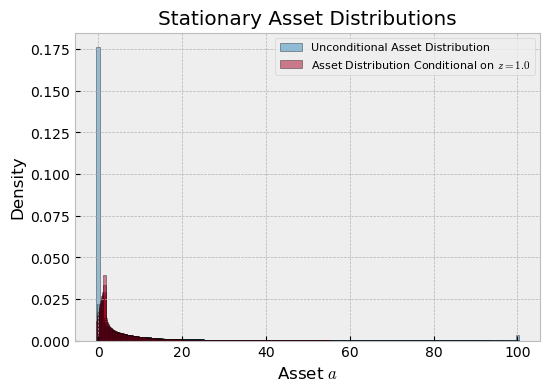

In [77]:
# Plotting the distribution of the aggregate and conditional on being in the middle state
# and higher assey value
plt.figure(figsize=(6, 4))

plt.bar(linear_state_grid, stationary_pmf, 
        alpha=.5, edgecolor='k',
        label='Unconditional Asset Distribution')

plt.bar(linear_state_grid, stationary_conditional_distribution_matrix[3, :], 
        alpha=.5, edgecolor='k',
        label=fr'Asset Distribution Conditional on $z = {round(state_grid_shock[3], 2)}$')

# Adding labels and title
plt.title('Stationary Asset Distributions')
plt.xlabel(r'Asset $a$')
plt.ylabel('Density')
plt.legend(loc='best', fontsize=8)

# Show the plot
plt.show()

#### Second Way

##### Assets

Instead of using the stationary distribution of shocks to "flatten" the invariant distribution matrix, we will work with the invariant distribution matrices in a flattened way.

Results are very similar to the ones above, but we can't quite plot the values since we end up with a num_shocks $\cdot$ num_states vector.

In [78]:
# Flattening
policy_a_flatten = aiyagari_solution_dict['policy_a_prime'].flatten(order='F')
stationary_pmf2 = stationary_distribution_matrix.flatten(order='F')

In [79]:
# Matrix for our states
linear_state_grid_matrix = np.empty_like(aiyagari_solution_dict['policy_a_prime'])

# Filling 
for index_shock in range(num_shocks):
    linear_state_grid_matrix[index_shock] = linear_state_grid

# Flattening
linear_state_grid_flatten = linear_state_grid_matrix.flatten(order='F')

In [80]:
# Getting CDF
stationary_cdf2 = np.cumsum(stationary_pmf2)

In [ ]:
# Quantile values
quantiles = [.01, .05, .1, .5, .9, .95, .99]
quantile_asset_values2 = get_values_from_quantiles(
    state_grid=linear_state_grid_flatten,
    stationary_cdf=stationary_cdf2,
    quantiles=quantiles
)

# Printing
for index, quantile in enumerate(quantiles):
    print(f"{int(100 * quantile)}% of Asset Distribution: {round(quantile_asset_values2[index], 2)}")

1% of Asset Distribution: 0.0
5% of Asset Distribution: 0.0
10% of Asset Distribution: 0.0
50% of Asset Distribution: 3.9
90% of Asset Distribution: 34.23
95% of Asset Distribution: 49.95
99% of Asset Distribution: 88.99


In [82]:
# Calculating gini
lorenz_curve2, lorenz_curve_norm2 = get_lorenz_curve(state_grid=linear_state_grid_flatten, 
                                                     stationary_pmf=stationary_pmf2)
gini2 = get_gini(lorenz_curve=lorenz_curve2, stationary_cdf=stationary_cdf2)

print(f"Gini of Wealth: {round(gini2, 3)}")

Gini of Wealth: 0.692


In [83]:
# Getting values using our interpolation function
share_asset_values2 = get_values_from_quantiles(
    state_grid=lorenz_curve_norm2,
    stationary_cdf=linear_state_grid_flatten,
    quantiles=quantile_asset_values2
)

# Printing
for index, quantile in enumerate(quantiles):
    print(f"Share of wealth at the {int(100 * quantile)}% of Asset Distribution: {round(100 * share_asset_values2[index], 1)}%")

Share of wealth at the 1% of Asset Distribution: 0.0%
Share of wealth at the 5% of Asset Distribution: 0.0%
Share of wealth at the 10% of Asset Distribution: 0.0%
Share of wealth at the 50% of Asset Distribution: 4.1%
Share of wealth at the 90% of Asset Distribution: 51.1%
Share of wealth at the 95% of Asset Distribution: 69.0%
Share of wealth at the 99% of Asset Distribution: 91.6%


##### Policy Assets

With this method we can also calculate the distribution of our policy assets, which, as expected, are fairly similar to the ones of the actual grid.

The exception is that the top 1% are responsible for a lower share of total "policy" asset wealth.

In [84]:
# Quantile values
quantiles = [.01, .05, .1, .5, .9, .95, .99]
quantile_asset_values_policy = get_values_from_quantiles(
    state_grid=policy_a_flatten,
    stationary_cdf=stationary_cdf2,
    quantiles=quantiles
)

# Printing
for index, quantile in enumerate(quantiles):
    print(f"{int(100 * quantile)}% of Policy Asset Distribution: {round(quantile_asset_values_policy[index], 2)}")

1% of Policy Asset Distribution: 0.0
5% of Policy Asset Distribution: 0.0
10% of Policy Asset Distribution: 0.0
50% of Policy Asset Distribution: 3.61
90% of Policy Asset Distribution: 33.69
95% of Policy Asset Distribution: 49.07
99% of Policy Asset Distribution: 87.13


In [85]:
# Calculating gini
lorenz_curve_policy, lorenz_curve_norm_policy = \
    get_lorenz_curve(state_grid=policy_a_flatten, 
                     stationary_pmf=stationary_pmf2)
gini_policy = get_gini(lorenz_curve=lorenz_curve_policy, stationary_cdf=stationary_cdf2)

print(f"Gini of Policy Wealth: {round(gini_policy, 3)}")

Gini of Policy Wealth: 0.691


In [86]:
# Getting values using our interpolation function
share_asset_values_policy = get_values_from_quantiles(
    state_grid=lorenz_curve_norm_policy,
    stationary_cdf=policy_a_flatten,
    quantiles=quantile_asset_values_policy
)

# Printing
for index, quantile in enumerate(quantiles):
    print(f"Share of wealth at the {int(100 * quantile)}% of Policy Asset Distribution: {round(100 * share_asset_values_policy[index], 1)}%")

Share of wealth at the 1% of Policy Asset Distribution: 0.0%
Share of wealth at the 5% of Policy Asset Distribution: 0.0%
Share of wealth at the 10% of Policy Asset Distribution: 0.0%
Share of wealth at the 50% of Policy Asset Distribution: 2.7%
Share of wealth at the 90% of Policy Asset Distribution: 49.4%
Share of wealth at the 95% of Policy Asset Distribution: 69.3%
Share of wealth at the 99% of Policy Asset Distribution: 90.8%


#### Third Way

Instead of the previous two methods, we will sum the invariant distribution across the shock dimension.

This is the way [Tomás Martinez](https://tomasrm.github.io/teaching/quantmacro/Aiyagari_EGM_notebook.jl.html) does it, and it so happens to match the results of the first way.

In [87]:
# Summing across shocks
stationary_pmf3 = np.sum(stationary_distribution_matrix, axis=0)
stationary_pmf3.shape

(1000,)

In [88]:
# Getting cumulative distribution
stationary_cdf3 = np.cumsum(stationary_pmf3)

In [89]:
# Quantile values
quantile_asset_values3 = get_values_from_quantiles(
    state_grid=linear_state_grid,
    stationary_cdf=stationary_cdf3,
    quantiles=quantiles
)

# Printing
for index, quantile in enumerate(quantiles):
    print(f"{int(100 * quantile)}% of Asset Distribution: {round(quantile_asset_values3[index], 2)}")

1% of Asset Distribution: 0.0
5% of Asset Distribution: 0.0
10% of Asset Distribution: 0.0
50% of Asset Distribution: 3.82
90% of Asset Distribution: 34.19
95% of Asset Distribution: 49.89
99% of Asset Distribution: 88.9


In [90]:
# Calculating gini
lorenz_curve3, lorenz_curve_norm3 = get_lorenz_curve(state_grid=linear_state_grid, stationary_pmf=stationary_pmf3)
gini3 = get_gini(lorenz_curve=lorenz_curve3, stationary_cdf=stationary_cdf3)

print(f"Gini of Wealth: {round(gini3, 3)}")

Gini of Wealth: 0.692


In [91]:
# Getting values using our interpolation function
share_asset_values3 = get_values_from_quantiles(
    state_grid=lorenz_curve_norm3,
    stationary_cdf=linear_state_grid,
    quantiles=quantile_asset_values3
)

# Printing
for index, quantile in enumerate(quantiles):
    print(f"Share of wealth at the {int(100 * quantile)}% of Asset Distribution: {round(100 * share_asset_values3[index], 1)}%")

Share of wealth at the 1% of Asset Distribution: 0.0%
Share of wealth at the 5% of Asset Distribution: 0.0%
Share of wealth at the 10% of Asset Distribution: 0.0%
Share of wealth at the 50% of Asset Distribution: 4.0%
Share of wealth at the 90% of Asset Distribution: 51.0%
Share of wealth at the 95% of Asset Distribution: 69.0%
Share of wealth at the 99% of Asset Distribution: 91.6%


In [92]:
# Fraction of credit constrained households
print(f"Share of credit-constrained households: {round(100 * stationary_pmf3[0], 2)}%")

Share of credit-constrained households: 17.6%


## Income Distribution

We define income as

$$
y(a, z) \coloneqq r \cdot a + w \cdot h \cdot z
$$

where $h = 1$ in this exogenous labour case.

Thus, it is the interest received on previous savings plus the labor income.

Note that we know the stationary distribution of $a$ and of $z$, so we can use them to compute the stationary distribution of $y$.

Note $y(a,z)$ is two-dimensional: we will use the second way of calculating distributions which we described above.

In [93]:
# As wealth, this is will be a num_shocks x num_states matrix
income_matrix = np.empty_like(linear_state_grid_matrix)

# Looping to fill
for index_shock in range(num_shocks):
    income_matrix[index_shock] = \
        aiyagari_solution_dict['r'] * linear_state_grid \
            + aiyagari_solution_dict['w'] * aiyagari_solution_dict['policy_h'][index_shock] * state_grid_shock[index_shock]

In [94]:
# Flattening
income_flatten = income_matrix.flatten(order='F')

In [95]:
# Getting quantile values
quantile_income_values = get_values_from_quantiles(
    state_grid=income_flatten,
    stationary_cdf=stationary_cdf2,
    quantiles=quantiles
)

# Printing
for index, quantile in enumerate(quantiles):
    print(f"{int(100 * quantile)}% of Income Distribution: {round(quantile_income_values[index], 2)}")

1% of Income Distribution: 0.23
5% of Income Distribution: 0.35
10% of Income Distribution: 0.53
50% of Income Distribution: 0.65
90% of Income Distribution: 3.33
95% of Income Distribution: 3.57
99% of Income Distribution: 3.52


In [96]:
# Calculating gini
lorenz_curve_income, lorenz_curve_norm_income = \
    get_lorenz_curve(state_grid=income_flatten, 
                     stationary_pmf=stationary_pmf2)

gini_income = get_gini(lorenz_curve=lorenz_curve_income, stationary_cdf=stationary_cdf2)

print(f"Gini of Wealth: {round(gini2, 3)}")
print(f"Gini of Income: {round(gini_income, 3)}")

Gini of Wealth: 0.692
Gini of Income: 0.36


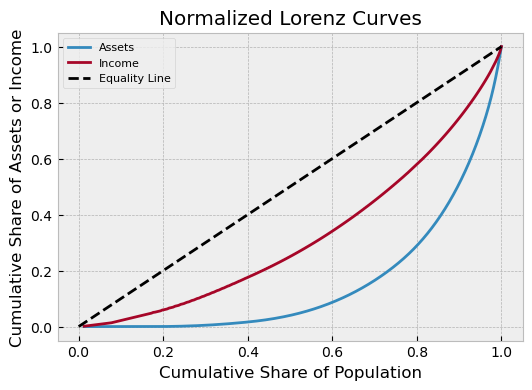

In [97]:
# Plotting (normalized) lorenz curve and comparing with wealth
plt.figure(figsize=(6, 4))

plt.plot(stationary_cdf2, lorenz_curve_norm2, label='Assets')
plt.plot(stationary_cdf2, lorenz_curve_norm_income, label='Income')

plt.plot([0, 1], [0, 1], color='black', linestyle='--', label='Equality Line')

# Adding labels and title
plt.title('Normalized Lorenz Curves')
plt.xlabel('Cumulative Share of Population')
plt.ylabel('Cumulative Share of Assets or Income')
plt.legend(loc='best', fontsize=8)

# Show the plot
plt.show()

We see that asset wealth is far more concentrated than income, as found by Aiyagari (1994).

## Bonus: Endogenous Labor

How do our results change when considering endogenous labor? We will set $\chi = 1$ and $\varphi = 3$ and see.

### Solution

In [98]:
# Copying param_dict
param_dict_endog = param_dict.copy()
param_dict_endog['chi'] = 1

In [99]:
# Solving for r using f_solve
aiyagari_opt_endog = fsolve(
    func=lambda r: excess_demand_capital(
        r_guess=r,
        transition_matrix=transition_matrix,
        stationary_shock_distribution=stationary_dist_shocks,
        state_grid=linear_state_grid,
        shock_grid=state_grid_shock,
        param_dict=param_dict_endog
    ),
    x0=r_guess,
    full_output=True
)

Stationary distribution converged in 571 iterations.
Stationary distribution converged in 571 iterations.
Stationary distribution converged in 571 iterations.
Stationary distribution converged in 571 iterations.
Stationary distribution converged in 617 iterations.
Stationary distribution converged in 629 iterations.
Stationary distribution converged in 630 iterations.
Stationary distribution converged in 630 iterations.
Stationary distribution converged in 630 iterations.
Stationary distribution converged in 630 iterations.


In [100]:
# Printing solution
r_market_clearing_endog = aiyagari_opt_endog[0][0]

print(f"Market clearing r with exogenous labor: {round(100 * r_market_clearing, 4)}%.")
print(f"Market clearing r with endogenous labor: {round(100 * r_market_clearing_endog, 4)}%.")

Market clearing r with exogenous labor: 1.2516%.
Market clearing r with endogenous labor: 0.2446%.


In [101]:
# Getting steady-state values
aiyagari_solution_dict_endog = aggregate_supply(
    r_guess=r_market_clearing_endog,
    transition_matrix=transition_matrix,
    stationary_shock_distribution=stationary_dist_shocks,
    state_grid=linear_state_grid,
    shock_grid=state_grid_shock,
    param_dict=param_dict_endog
)

Stationary distribution converged in 630 iterations.


In [102]:
# Wage
print(f"Wage with exogenous labor: {round(aiyagari_solution_dict['w'], 2)}")
print(f"Wage with endogenous labor: {round(aiyagari_solution_dict_endog['w'], 2)}")

Wage with exogenous labor: 1.59
Wage with endogenous labor: 1.72


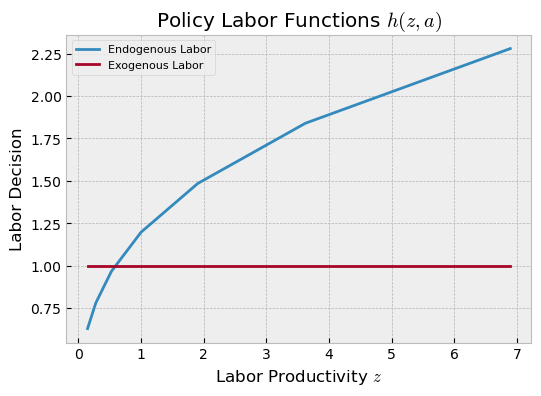

In [103]:
# Printing policy function of labor
plt.figure(figsize=(6, 4))

plt.plot(state_grid_shock, aiyagari_solution_dict_endog['policy_h'],
         label='Endogenous Labor')
plt.plot(state_grid_shock, aiyagari_solution_dict['policy_h'],
         label='Exogenous Labor')

# Adding labels and title
plt.title(fr'Policy Labor Functions $h(z, a)$')
plt.xlabel('Labor Productivity $z$')
plt.ylabel('Labor Decision')
plt.legend(loc='best', fontsize=8)

With endogenous labor supply, the interest rate is now lower than in the exogenous case.

Note that the firm side of the model is the same: the only thing that changes is the household.
Thus, labor demand is the same.

As now labor provides disutility, firms have to pay a higher wage in order for the market to clear. Since

$$
w = (1 - \alpha) \left( \frac{\alpha}{r + \delta} \right)^{\frac{\alpha}{1 - \alpha}}
$$

$r$ must decrease.

### Supply and Demand

In [122]:
# Skeletons of capital to labor supply and demand
capital_labor_demand_grid_endog = np.zeros([num_points_supply_demand])
capital_labor_supply_grid_endog = np.zeros([num_points_supply_demand])

# Iterating
for index, r in enumerate(r_grid):
    # Demand of firms
    capital_labor_demand_grid_endog[index] = aggregate_demand(r, param_dict_endog)

    # Supply of households
    aiyagari_solution_dict_supply_demand_endog = aggregate_supply(
        r_guess=r,
        transition_matrix=transition_matrix,
        stationary_shock_distribution=stationary_dist_shocks,
        state_grid=linear_state_grid,
        shock_grid=state_grid_shock,
        param_dict=param_dict_endog,
        print_convergence=False
    )
    capital_labor_supply_grid_endog[index] = aiyagari_solution_dict_supply_demand_endog['K_H_ratio']

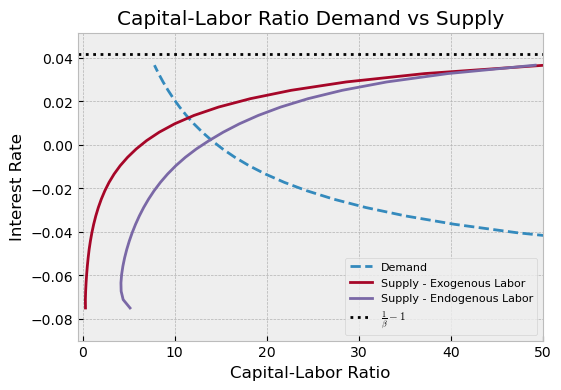

In [123]:
# Plotting
plt.figure(figsize=(6, 4))

plt.plot(capital_labor_demand_grid, r_grid, 
         label='Demand', linestyle='--')

plt.plot(capital_labor_supply_grid, r_grid, 
         label='Supply - Exogenous Labor')
plt.plot(capital_labor_supply_grid_endog, r_grid, 
         label='Supply - Endogenous Labor')

plt.axhline(y=r_ub, color='k', linestyle='dotted', label=r'$\frac{1}{\beta} - 1$')

# Adding labels and title
plt.title('Capital-Labor Ratio Demand vs Supply')
plt.xlabel('Capital-Labor Ratio')
plt.ylabel('Interest Rate')
plt.legend(loc='best', fontsize=8)

# Limiting the axis
plt.xlim(-0.5, 50)
plt.ylim(r_lb - 0.01, r_ub + 0.01)

# Show the plot
plt.show()

Note that, for a given interest rate, the capital-labor ratio is bigger in the endogenous case (conversely, for a given capital-labor ratio, the interest rate is higher in the exogenous labor case).

This can be because (1) individuals work less for the wage implied by the interest rate or (2) we have more assets in the economy.

### Investment Rate and Capital-Output Ratio

In [106]:
# Capital is equal to bond stock due to market clearing
aggregate_K_endog = aiyagari_solution_dict_endog['aggregate_K']

# Output is given by Cobb-Douglas
aggregate_H_endog = aiyagari_solution_dict_endog['aggregate_H']
aggregate_Y_endog = (aggregate_K_endog ** alpha) * (aggregate_H_endog ** (1 - alpha))

In [107]:
# Printing results
print(f"Exogenous Labor Supply")
print(f"Capital: {round(aggregate_K, 2)}")
print(f"Labor: {round(aggregate_H, 2)}")
print(f"Output: {round(aggregate_Y, 2)}")

print(f"Capital-to-Output Ratio: {round(aggregate_K / aggregate_Y, 2)}")
print(f"Capital-to-Labor Ratio: {round(aggregate_K / aggregate_H, 2)}")

print(f"Gross Investment: {round(delta * aggregate_K, 2)}")
print(f"Investment Rate: {round(100 * delta * aggregate_K / aggregate_Y, 1)}%")

print(f"\nEndogenous Labor Supply")
print(f"Capital: {round(aggregate_K_endog, 2)}")
print(f"Labor: {round(aggregate_H_endog, 2)}")
print(f"Output: {round(aggregate_Y_endog, 2)}")

print(f"Capital-to-Output Ratio: {round(aggregate_K_endog / aggregate_Y_endog, 2)}")
print(f"Capital-to-Labor Ratio: {round(aggregate_K_endog / aggregate_H_endog, 2)}")

print(f"Gross Investment: {round(delta * aggregate_K_endog, 2)}")
print(f"Investment Rate: {round(100 * delta * aggregate_K_endog / aggregate_Y_endog, 1)}%")

Exogenous Labor Supply
Capital: 11.47
Labor: 1.0
Output: 2.65
Capital-to-Output Ratio: 4.32
Capital-to-Labor Ratio: 11.47
Gross Investment: 0.92
Investment Rate: 34.6%

Endogenous Labor Supply
Capital: 17.24
Labor: 1.24
Output: 3.55
Capital-to-Output Ratio: 4.85
Capital-to-Labor Ratio: 13.9
Gross Investment: 1.38
Investment Rate: 38.8%


With endogenous labor, the economy is better on aggregate: the lower interest rate allows more capital accumulation and the more productive choose to work more due to the effective labor on the budget constraint.

### Wealth Distribution

In [108]:
# Getting stationary distribution
stationary_distribution_matrix_endog = aiyagari_solution_dict_endog['stationary_distribution']

# To get the unconditional distribution, we first must transform the above into
# conditional probabilities, so that each row sums to 1
## Skeleton
stationary_conditional_distribution_matrix_endog = stationary_distribution_matrix_endog.copy()

## Looping
for index_shock in range(num_shocks):
    for index_state in range(num_states):
        stationary_conditional_distribution_matrix_endog[index_shock, index_state] = \
            stationary_distribution_matrix_endog[index_shock, index_state] \
                / np.sum(stationary_distribution_matrix_endog[index_shock])


In [109]:
# Calculating the probability mass function at each grid point: we multiply the above matrix
# by the stationary distribution of shocks to get the actual unconditional
# distribution of assets in the economy in the stationary equilibrium
stationary_pmf_endog = (stationary_dist_shocks @ stationary_conditional_distribution_matrix_endog)

# Getting cumulative distribution
stationary_cdf_endog = np.cumsum(stationary_pmf_endog)

In [110]:
# Quantile values
quantile_asset_values_endog = get_values_from_quantiles(
    state_grid=linear_state_grid,
    stationary_cdf=stationary_cdf_endog,
    quantiles=quantiles
)

# Printing
for index, quantile in enumerate(quantiles):
    print(f"{int(100 * quantile)}% of Asset Distribution:")
    print(f"Exogenous: {round(quantile_asset_values[index], 2)}")
    print(f"Endogenous: {round(quantile_asset_values_endog[index], 2)}\n")

1% of Asset Distribution:
Exogenous: 0.0
Endogenous: 0.0

5% of Asset Distribution:
Exogenous: 0.0
Endogenous: 0.0

10% of Asset Distribution:
Exogenous: 0.0
Endogenous: 0.05

50% of Asset Distribution:
Exogenous: 3.82
Endogenous: 6.37

90% of Asset Distribution:
Exogenous: 34.19
Endogenous: 54.15

95% of Asset Distribution:
Exogenous: 49.89
Endogenous: 77.55

99% of Asset Distribution:
Exogenous: 88.9
Endogenous: 99.95



In [111]:
# Calculating gini
lorenz_curve_endog, lorenz_curve_norm_endog = \
    get_lorenz_curve(state_grid=linear_state_grid, stationary_pmf=stationary_pmf_endog)

gini_endog = get_gini(lorenz_curve=lorenz_curve_endog, stationary_cdf=stationary_cdf_endog)

print(f"Gini of Wealth with Exogenous Labor: {round(gini, 3)}")
print(f"Gini of Wealth with Endogenous Labor: {round(gini_endog, 3)}")

Gini of Wealth with Exogenous Labor: 0.692
Gini of Wealth with Endogenous Labor: 0.665


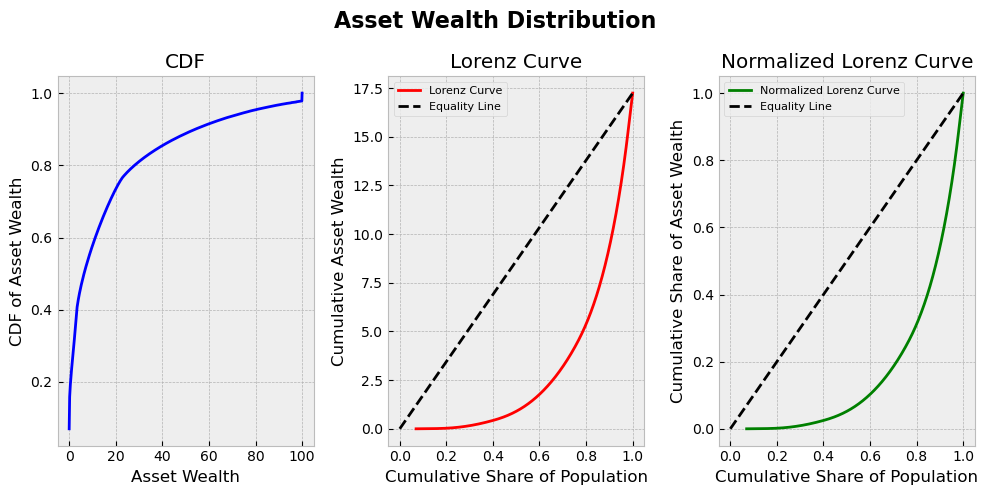

In [112]:
plot_cdf_and_lorenz(
    state_grid=linear_state_grid,
    lorenz_curve=lorenz_curve_endog,
    lorenz_curve_norm=lorenz_curve_norm_endog,
    stationary_cdf=stationary_cdf_endog,
    variable='Asset Wealth'
)

In [113]:
# Fraction of credit constrained households
print(f"Share of credit-constrained households with exogenous labor: {round(100 * stationary_pmf[0], 2)}%")
print(f"Share of credit-constrained households with endogenous labor: {round(100 * stationary_pmf_endog[0], 2)}%")

Share of credit-constrained households with exogenous labor: 17.6%
Share of credit-constrained households with endogenous labor: 7.02%


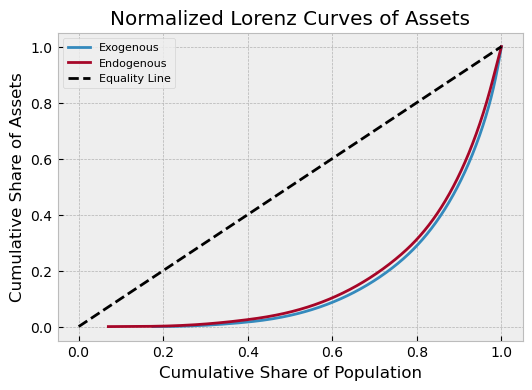

In [114]:
# Compariing lorenz curves
plt.figure(figsize=(6, 4))

plt.plot(stationary_cdf, lorenz_curve_norm, label='Exogenous')
plt.plot(stationary_cdf_endog, lorenz_curve_norm_endog, label='Endogenous')

plt.plot([0, 1], [0, 1], color='black', linestyle='--', label='Equality Line')

# Adding labels and title
plt.title('Normalized Lorenz Curves of Assets')
plt.xlabel('Cumulative Share of Population')
plt.ylabel('Cumulative Share of Assets')
plt.legend(loc='best', fontsize=8)

# Show the plot
plt.show()

The endogenous-labor distribution is slightly less unequal than the one with endogenous labor, which I think has to do with the lower interest rate: no reason why accumulate so many assets.

### Income

In [115]:
# As wealth, this is will be a num_shocks x num_states matrix
income_matrix_endog = np.empty_like(linear_state_grid_matrix)

# Looping to fill
for index_shock in range(num_shocks):
    income_matrix_endog[index_shock] = \
        aiyagari_solution_dict_endog['r'] * linear_state_grid \
            + aiyagari_solution_dict_endog['w'] * aiyagari_solution_dict_endog['policy_h'][index_shock] * state_grid_shock[index_shock]

In [116]:
# Flattening
income_flatten_endog = income_matrix_endog.flatten(order='F')

In [117]:
# We will also have to supply the distribution matrix
stationary_pmf2_endog = stationary_distribution_matrix_endog.flatten(order='F')
stationary_cdf2_endog = np.cumsum(stationary_pmf2_endog)

In [118]:
# Calculating gini
lorenz_curve_income_endog, lorenz_curve_norm_income_endog = \
    get_lorenz_curve(state_grid=income_flatten_endog, 
                     stationary_pmf=stationary_pmf2_endog)

gini_income_endog = get_gini(lorenz_curve=lorenz_curve_income_endog, stationary_cdf=stationary_cdf2_endog)

print(f"Gini of income with exogenous labor: {round(gini_income, 3)}")
print(f"Gini of income with endogenous labor: {round(gini_income_endog, 3)}")

Gini of income with exogenous labor: 0.36
Gini of income with endogenous labor: 0.45


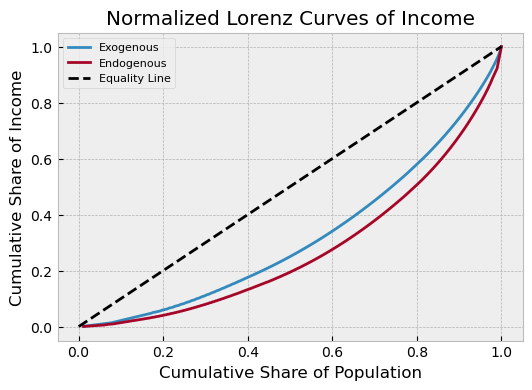

In [119]:
# Compariing lorenz curves
plt.figure(figsize=(6, 4))

plt.plot(stationary_cdf2, lorenz_curve_norm_income, label='Exogenous')
plt.plot(stationary_cdf2_endog, lorenz_curve_norm_income_endog, label='Endogenous')

plt.plot([0, 1], [0, 1], color='black', linestyle='--', label='Equality Line')

# Adding labels and title
plt.title('Normalized Lorenz Curves of Income')
plt.xlabel('Cumulative Share of Population')
plt.ylabel('Cumulative Share of Income')
plt.legend(loc='best', fontsize=8)

# Show the plot
plt.show()

Contrary to wealth, the distribution of income is now more concentrated, as those that are more productive choose to work more and, thus, have higher labor income.

# (h) Calibration of $\beta$ to get $r = 4\%$

We will change $\beta$ until we get a $r$ of 4%.
For that, we will use a root finding algorithm.

For each guess of $\beta$, we will solve the model and find the market clearing interest rate $r(\beta)$.
We will then compare with our desired $r^* = 4%$, updating the guess of $\beta$ following the root finder algorithm routine.

We will stop when we've found a root of $r(\beta) - r^*$.

In [120]:
# Copying param_dict
param_dict_calibration_beta = param_dict.copy()

In [121]:
# Desired r
desired_r = 0.04

In [122]:
# Function to find beta
def find_beta_r(desired_r, 
                beta, 
                param_dict_calibration,
                transition_matrix=transition_matrix,
                stationary_shock_distribution=stationary_dist_shocks,
                state_grid=linear_state_grid,
                shock_grid=state_grid_shock):
    
    # Assigning value of beta
    param_dict_calibration['beta'] = beta

    # Solving the model
    aiyagari_opt_calibration = fsolve(
        func=lambda r: excess_demand_capital(
            r_guess=r,
            transition_matrix=transition_matrix,
            stationary_shock_distribution=stationary_shock_distribution,
            state_grid=state_grid,
            shock_grid=shock_grid,
            param_dict=param_dict_calibration,
            print_convergence=False
        ),
        x0=r_guess,
        full_output=True
    )

    # Getting r of market clearing
    r_market_clearing = aiyagari_opt_calibration[0][0]

    # Returning the difference between the found r and the desired r
    return r_market_clearing - desired_r

In [123]:
# Solving for beta using brentq, which is better since beta is between 0 and 1
t0 = time.time()

aiyagari_opt_beta = brentq(
    f=lambda beta: find_beta_r(
        beta=beta,
        desired_r=desired_r,
        param_dict_calibration=param_dict_calibration_beta
    ),
    a=.5,
    b=1,
    full_output=True
)

t_calibration_beta = time.time() - t0
print(f"Took {int(t_calibration_beta)} seconds.")

Took 37 seconds.


In [124]:
# Printing solution
beta_desired_r = aiyagari_opt_beta[1]['root']
num_iter_beta = aiyagari_opt_beta[1]['iterations']

print(f"Beta such that market clearing r = {100 * int(desired_r)}%: {round(beta_desired_r, 4)}")
print(f"Iterations of brentq: {num_iter_beta}.")

Beta such that market clearing r = 0%: 0.9319
Iterations of brentq: 8.


In [125]:
# Checking just to be safe: all good!
fsolve(
    func=lambda r: excess_demand_capital(
        r_guess=r,
        transition_matrix=transition_matrix,
        stationary_shock_distribution=stationary_dist_shocks,
        state_grid=linear_state_grid,
        shock_grid=state_grid_shock,
        param_dict=param_dict_calibration_beta,
        print_convergence=False
    ),
    x0=r_guess,
    full_output=True
)[0][0]

0.04000000000093481

# (i.1) Calibration of $\sigma_z^2$ to get $\frac{p_{90}}{p_{10}}$ of Wealth = 7

Here, we have a problem: $\frac{p_{90}}{p_{10}}$ is not defined in our original problem due to the lowest 10% being debt constrained, and so we have a division by zero.

First we will do some exercises with $\sigma_z^2$ to see how it changes the wealth distribution.

In our tests, which we keep below, no matter the shock variance - absurdly low or absurdly high -, we couldn't get $\frac{p90}{p10}$ to be 7 while having the model to be in general equilibrium (that is, with an $r$ that clears the capital-labor market).
This remained the same using both Tauchen and Rouwenhorst for discretization of the shock space.

### Functions to Solve the Model

In [126]:
# Functions to do things more easily
def get_sigma_error(variance_z, rho):
    return (variance_z * (1 - rho ** 2)) ** (1 / 2)

def discretize_ar1_log_shock(num_shocks, rho, sigma_error, 
                             mu=0, method=method, num_std=3):
    """
    Discretizes an AR(1) process and returns the state grid and transition
    matrix that characterizes the associated Markov Chain 
    """

    # Approximating the process with the desired method
    if method == 'tauchen':
        discrete_ln_shock = tauchen(n=num_shocks, rho=rho, 
                                    sigma=sigma_error, mu=mu, n_std=num_std)
    else:
        discrete_ln_shock = rouwenhorst(n=num_shocks, rho=rho,
                                        sigma=sigma_error, mu=mu)
    
    # Getting objects
    grid_ln_shock = discrete_ln_shock.state_values
    grid_shock = np.exp(grid_ln_shock)
    shock_transition_matrix = discrete_ln_shock.P

    return grid_shock, shock_transition_matrix

In [127]:
def solve_aiyagari(state_grid, param_dict,
                   num_shocks, rho_shock, variance_shock,
                   mu_shock=0, method_shock=method, 
                   num_std_shock=3, r_initial_guess=0.02,
                   max_iter_hh=10_000, tol_hh=1e-6,
                   max_iter_stat_dist=10_000, tol_stat_dist=1e-12, print_convergence=False):
    """
    Solves the whole Aiyagari model, from discretization of AR(1) shocks
    to finding the market clearing interest rate.
    """

    # 1. Discretizing the shock
    sigma_error = get_sigma_error(variance_shock, rho_shock)
        
    shock_grid, transition_matrix = discretize_ar1_log_shock(
        num_shocks=num_shocks,
        rho=rho_shock,
        sigma_error=sigma_error,
        mu=mu_shock,
        method=method_shock,
        num_std=num_std_shock
    )
    
    # 2. Getting the stationary distribution of shocks
    stationary_dist_shocks = get_stationary_distribution_shocks(
        transition_matrix=transition_matrix,
        print_convergence=print_convergence
    )

    # 3. Solving the model
    aiyagari_opt = fsolve(
        func=lambda r: excess_demand_capital(
            r_guess=r,
            transition_matrix=transition_matrix,
            stationary_shock_distribution=stationary_dist_shocks,
            state_grid=state_grid,
            shock_grid=shock_grid,
            param_dict=param_dict,
            max_iter_hh=max_iter_hh,
            tol_hh=tol_hh,
            max_iter_stat_dist=max_iter_stat_dist,
            tol_stat_dist=tol_stat_dist,
            print_convergence=print_convergence
        ),
        x0=r_initial_guess,
        full_output=True
    )

    # 4. Getting solution
    r_market_clearing = aiyagari_opt[0][0]

    aiyagari_solution_dict = aggregate_supply(
        r_guess=r_market_clearing,
        transition_matrix=transition_matrix,
        stationary_shock_distribution=stationary_dist_shocks,
        state_grid=state_grid,
        shock_grid=shock_grid,
        param_dict=param_dict,
        max_iter_hh=max_iter_hh,
        tol_hh=tol_hh,
        max_iter_stat_dist=max_iter_stat_dist,
        tol_stat_dist=tol_stat_dist,
        print_convergence=print_convergence
    )

    # Returning solution dictionary and stationary distribution of shocks
    return aiyagari_solution_dict

In [128]:
def calculate_distribution_statistics(aiyagari_solution_dict, 
                                      state_grid,
                                      quantiles=[.01, .05, .1, .5, .9, .95, .99]):
    """ 
    Given the solution dictionary of Aiyagari's model, calculates the stationary asset distribution
    of the economy and some distributional statistics.
    """

    # 0. Primitives
    shock_grid = aiyagari_solution_dict['shock_grid']
    stationary_shock_distribution = aiyagari_solution_dict['stationary_shock_distribution']
    num_shocks = shock_grid.shape[0]
    num_states = state_grid.shape[0]

    # 1. Calculating stationary asset distribution
    stationary_distribution_matrix = aiyagari_solution_dict['stationary_distribution']
    

    # To get the unconditional distribution, we first must transform the above into
    # conditional probabilities, so that each row sums to 1
    ## Skeleton
    stationary_conditional_distribution_matrix = stationary_distribution_matrix.copy()

    ## Looping
    for index_shock in range(num_shocks):
        for index_state in range(num_states):
            stationary_conditional_distribution_matrix[index_shock, index_state] = \
                stationary_distribution_matrix[index_shock, index_state] \
                    / np.sum(stationary_distribution_matrix[index_shock])
    
    # Calculating the probability mass function at each grid point: we multiply the above matrix
    # by the stationary distribution of shocks to get the actual unconditional
    # distribution of assets in the economy in the stationary equilibrium
    stationary_shock_distribution = aiyagari_solution_dict['stationary_shock_distribution']
    stationary_pmf = stationary_shock_distribution @ stationary_conditional_distribution_matrix

    # Getting cumulative distribution
    stationary_cdf = np.cumsum(stationary_pmf)

    # 2. Quantile values
    ## Values
    quantile_asset_values = get_values_from_quantiles(
        state_grid=state_grid,
        stationary_cdf=stationary_cdf,
        quantiles=quantiles
    )

    ## Dictionary
    quantile_values_dict = dict(zip(quantiles, quantile_asset_values))

    # 3. Gini and lorenz curves
    lorenz_curve, lorenz_curve_norm = get_lorenz_curve(state_grid=state_grid, stationary_pmf=stationary_pmf)
    gini = get_gini(lorenz_curve=lorenz_curve, stationary_cdf=stationary_cdf)

    # 4. Calculating stationary income distribution
    ## Skeleton
    income_matrix = np.zeros([num_shocks, num_states])

    ## Looping to fill
    for index_shock in range(num_shocks):
        income_matrix[index_shock] = \
            aiyagari_solution_dict['r'] * state_grid \
                + aiyagari_solution_dict['w'] * aiyagari_solution_dict['policy_h'][index_shock] * shock_grid[index_shock]
    
    ## Flattening
    income_flatten = income_matrix.flatten(order='F')

    ## Getting flattened distribution
    stationary_pmf_flatten = stationary_distribution_matrix.flatten(order='F')
    stationary_cdf_flatten = np.cumsum(stationary_pmf_flatten)

    ## Calculating gini
    lorenz_curve_income, lorenz_curve_norm_income = get_lorenz_curve(
        state_grid=income_flatten, 
        stationary_pmf=stationary_pmf_flatten
    )
    
    gini_income = get_gini(lorenz_curve=lorenz_curve_income, stationary_cdf=stationary_cdf_flatten)

    ## Calculating qunaitle income values
    quantile_income_values = get_values_from_quantiles(
        state_grid=income_flatten,
        stationary_cdf=stationary_cdf_flatten,
        quantiles=quantiles
    )

    ## Dictionary
    quantile_income_values_dict = dict(zip(quantiles, quantile_income_values))

    # Returning dictionary
    return dict(
        stationary_distribution_matrix=stationary_distribution_matrix,
        stationary_pmf=stationary_pmf,
        stationary_cdf=stationary_cdf,
        quantile_values_dict=quantile_values_dict,
        lorenz_curve=lorenz_curve,
        lorenz_curve_norm=lorenz_curve_norm,
        gini=gini,
        income_array=income_flatten,
        stationary_pmf_flatten=stationary_pmf_flatten,
        stationary_cdf_flatten=stationary_cdf_flatten,
        lorenz_curve_income=lorenz_curve_income,
        lorenz_curve_norm_income=lorenz_curve_norm_income,
        gini_income=gini_income,
        quantile_income_values_dict=quantile_income_values_dict
    )

### Functions for Calibration

In [129]:
def distance_desired_r(r, desired_r):
    return r - desired_r

In [130]:
def distance_desired_p90_p10(distribution_dict, desired_ratio):
    # Calculating ratio
    ## Quantile values
    quantile_values_dict = distribution_dict['quantile_values_dict']

    ## Ratio: have to consider we may get 0 at the 10th percentile
    if quantile_values_dict[0.1] != 0:
        ratio = quantile_values_dict[0.9] / quantile_values_dict[0.1]
    else:
        ratio = np.Inf
    
    return ratio - desired_ratio

## Tests

We now see how the model solution changes for different values of $\sigma_z^2$.

In [131]:
# Parameters
absurd_low_variance_shock = 0.001
super_low_variance_shock = 0.01
low_variance_shock = 0.2
high_variance_shock = 1
super_high_variance_shock = 10
absurd_high_variance_shock = 100

# Solving the model for these values
t0 = time.time()
aiyagari_solution_dict_absurd_low_variance_shock = solve_aiyagari(
    state_grid=linear_state_grid,
    param_dict=param_dict,
    num_shocks=num_shocks,
    rho_shock=rho,
    variance_shock=absurd_low_variance_shock,
    max_iter_stat_dist=100_000,
    tol_stat_dist=1e-4
)

aiyagari_solution_dict_super_low_variance_shock = solve_aiyagari(
    state_grid=linear_state_grid,
    param_dict=param_dict,
    num_shocks=num_shocks,
    rho_shock=rho,
    variance_shock=super_low_variance_shock,
    max_iter_stat_dist=100_000,
    tol_stat_dist=1e-8
)

aiyagari_solution_dict_low_variance_shock = solve_aiyagari(
    state_grid=linear_state_grid,
    param_dict=param_dict,
    num_shocks=num_shocks,
    rho_shock=rho,
    variance_shock=low_variance_shock,
    max_iter_stat_dist=100_000,
    tol_stat_dist=1e-8
)

aiyagari_solution_dict_high_variance_shock = solve_aiyagari(
    state_grid=linear_state_grid,
    param_dict=param_dict,
    num_shocks=num_shocks,
    rho_shock=rho,
    variance_shock=high_variance_shock,
    max_iter_stat_dist=100_000,
    tol_stat_dist=1e-8
)

aiyagari_solution_dict_super_high_variance_shock = solve_aiyagari(
    state_grid=linear_state_grid,
    param_dict=param_dict,
    num_shocks=num_shocks,
    rho_shock=rho,
    variance_shock=super_high_variance_shock,
    max_iter_stat_dist=100_000,
    tol_stat_dist=1e-8
)

aiyagari_solution_dict_absurd_high_variance_shock = solve_aiyagari(
    state_grid=linear_state_grid,
    param_dict=param_dict,
    num_shocks=num_shocks,
    rho_shock=rho,
    variance_shock=absurd_high_variance_shock,
    max_iter_hh=15_000,
    tol_hh=1e-4,
    max_iter_stat_dist=100_000,
    tol_stat_dist=1e-8
)

print(f"Took {round((time.time() - t0) / 60, 1)} minutes.")

Took 1.2 minutes.


In [132]:
# Calculating distributions
distribution_dict_absurd_low_variance_shock = calculate_distribution_statistics(
    aiyagari_solution_dict=aiyagari_solution_dict_absurd_low_variance_shock,
    state_grid=linear_state_grid
)

distribution_dict_super_low_variance_shock = calculate_distribution_statistics(
    aiyagari_solution_dict=aiyagari_solution_dict_super_low_variance_shock,
    state_grid=linear_state_grid
)

distribution_dict_low_variance_shock = calculate_distribution_statistics(
    aiyagari_solution_dict=aiyagari_solution_dict_low_variance_shock,
    state_grid=linear_state_grid
)

distribution_dict_high_variance_shock = calculate_distribution_statistics(
    aiyagari_solution_dict=aiyagari_solution_dict_high_variance_shock,
    state_grid=linear_state_grid
)

distribution_dict_super_high_variance_shock = calculate_distribution_statistics(
    aiyagari_solution_dict=aiyagari_solution_dict_super_high_variance_shock,
    state_grid=linear_state_grid
)

distribution_dict_absurd_high_variance_shock = calculate_distribution_statistics(
    aiyagari_solution_dict=aiyagari_solution_dict_absurd_high_variance_shock,
    state_grid=linear_state_grid
)

In [133]:
# Statistics
print(f"Benchmark model ({variance_z}):")
print(f"r: {round(100 * r_market_clearing, 2)}")
print(f"Gini: {round(gini, 2)}")
print(f"Share of credit-constrained households: {round(100 * stationary_pmf[0], 2)}%")

print(f"\nAbsurdly low shock variance ({absurd_low_variance_shock}):")
print(f"r: {round(100 * aiyagari_solution_dict_absurd_low_variance_shock['r'], 2)}")
print(f"Gini: {round(distribution_dict_absurd_low_variance_shock['gini'], 2)}")
print(f"Quantiles: {distribution_dict_absurd_low_variance_shock['quantile_values_dict']}")
print(f"Share of credit-constrained households: {round(100 * distribution_dict_absurd_low_variance_shock['stationary_pmf'][0], 2)}%")

print(f"\nSuper low shock variance ({super_low_variance_shock}):")
print(f"r: {round(100 * aiyagari_solution_dict_super_low_variance_shock['r'], 2)}")
print(f"Gini: {round(distribution_dict_super_low_variance_shock['gini'], 2)}")
print(f"Quantiles: {distribution_dict_super_low_variance_shock['quantile_values_dict']}")
print(f"Share of credit-constrained households: {round(100 * distribution_dict_super_low_variance_shock['stationary_pmf'][0], 2)}%")

print(f"\nLow shock variance ({low_variance_shock}):")
print(f"r: {round(100 * aiyagari_solution_dict_low_variance_shock['r'], 2)}")
print(f"Gini: {round(distribution_dict_low_variance_shock['gini'], 2)}")
print(f"Quantiles: {distribution_dict_low_variance_shock['quantile_values_dict']}")
print(f"Share of credit-constrained households: {round(100 * distribution_dict_low_variance_shock['stationary_pmf'][0], 2)}%")

print(f"\nHigh shock variance ({high_variance_shock}):")
print(f"r: {round(100 * aiyagari_solution_dict_high_variance_shock['r'], 2)}")
print(f"Gini: {round(distribution_dict_high_variance_shock['gini'], 2)}")
print(f"Quantiles: {distribution_dict_high_variance_shock['quantile_values_dict']}")
print(f"Share of credit-constrained households: {round(100 * distribution_dict_high_variance_shock['stationary_pmf'][0], 2)}%")

print(f"\nSuper high shock variance ({super_high_variance_shock}):")
print(f"r: {round(100 * aiyagari_solution_dict_super_high_variance_shock['r'], 2)}")
print(f"Gini: {round(distribution_dict_super_high_variance_shock['gini'], 2)}")
print(f"Quantiles: {distribution_dict_super_high_variance_shock['quantile_values_dict']}")
print(f"Share of credit-constrained households: {round(100 * distribution_dict_super_high_variance_shock['stationary_pmf'][0], 2)}%")

print(f"\nAbsurdly high shock variance ({absurd_high_variance_shock}):")
print(f"r: {round(100 * aiyagari_solution_dict_absurd_high_variance_shock['r'], 2)}")
print(f"Gini: {round(distribution_dict_absurd_high_variance_shock['gini'], 2)}")
print(f"Quantiles: {distribution_dict_absurd_high_variance_shock['quantile_values_dict']}")
print(f"Share of credit-constrained households: {round(100 * distribution_dict_absurd_high_variance_shock['stationary_pmf'][0], 2)}%")


Benchmark model (0.621):
r: 1.25
Gini: 0.69
Share of credit-constrained households: 17.6%

Absurdly low shock variance (0.001):
r: 3.75
Gini: 1.0
Quantiles: {0.01: 0.0, 0.05: 0.0, 0.1: 0.0, 0.5: 0.0, 0.9: 0.0, 0.95: 0.0, 0.99: 0.0}
Share of credit-constrained households: 99.47%

Super low shock variance (0.01):
r: 4.09
Gini: 0.54
Quantiles: {0.01: 0.0, 0.05: 0.0, 0.1: 0.0, 0.5: 5.13696975670994, 0.9: 17.889831450268687, 0.95: 22.263846621102413, 0.99: 31.060351974365403}
Share of credit-constrained households: 10.13%

Low shock variance (0.2):
r: 3.08
Gini: 0.65
Quantiles: {0.01: 0.0, 0.05: 0.0, 0.1: 0.0, 0.5: 3.660130836011902, 0.9: 24.073924943445405, 0.95: 33.0368464955466, 0.99: 52.847914429321996}
Share of credit-constrained households: 17.35%

High shock variance (1):
r: -0.06
Gini: 0.69
Quantiles: {0.01: 0.0, 0.05: 0.0, 0.1: 0.0, 0.5: 4.626730919328627, 0.9: 47.20958097600845, 0.95: 68.9930204520686, 0.99: 99.5526204212986}
Share of credit-constrained households: 11.82%

Super h

We see some improvement with super high shock variances: now the 10% hold some assets.
However, this seems like a two-edged knife, as now the top 10% hold more assets.

It seems that we have some hope with super low variances: the share of credit-constrained falls and the amount held by the top 10% is also lower.

A better approach than adjusting the variance would be to adjust the span of our shock grid, which seems much to large.

In the same way, artificially reducing the state grid could work.

In [134]:
print(f"p90 p10 ratio with shock variance = {absurd_low_variance_shock}: {distance_desired_p90_p10(distribution_dict_absurd_low_variance_shock, 0)}")
print(f"p90 p10 ratio with shock variance = {super_low_variance_shock}: {distance_desired_p90_p10(distribution_dict_super_low_variance_shock, 0)}")
print(f"p90 p10 ratio with shock variance = {low_variance_shock}: {distance_desired_p90_p10(distribution_dict_low_variance_shock, 0)}")
print(f"p90 p10 ratio with shock variance = {high_variance_shock}: {distance_desired_p90_p10(distribution_dict_high_variance_shock, 0)}")
print(f"p90 p10 ratio with shock variance = {super_high_variance_shock}: {distance_desired_p90_p10(distribution_dict_super_high_variance_shock, 0)}")
print(f"p90 p10 ratio with shock variance = {absurd_high_variance_shock}: {distance_desired_p90_p10(distribution_dict_absurd_high_variance_shock, 0)}")

p90 p10 ratio with shock variance = 0.001: inf
p90 p10 ratio with shock variance = 0.01: inf
p90 p10 ratio with shock variance = 0.2: inf
p90 p10 ratio with shock variance = 1: inf
p90 p10 ratio with shock variance = 10: 87.32043126434439
p90 p10 ratio with shock variance = 100: 58.545167076018025


## Calibration

In [135]:
# Function to find the variance
def find_variance_quantile_ratio(variance_shock, desired_ratio,
                                 param_dict_calibration, state_grid,
                                 num_shocks, rho_shock,
                                 distance_function,
                                 mu_shock=0, method_shock=method, 
                                 num_std_shock=3, r_initial_guess=0.02,
                                 max_iter_hh=10_000, tol_hh=1e-6,
                                 max_iter_stat_dist=10_000, tol_stat_dist=1e-12, print_convergence=False):
    
    # 1. Solve Aiyagari model
    aiyagari_solution_dict = solve_aiyagari(
        state_grid=state_grid,
        param_dict=param_dict_calibration,
        num_shocks=num_shocks, 
        rho_shock=rho_shock, 
        variance_shock=variance_shock,
        mu_shock=mu_shock, 
        method_shock=method_shock, 
        num_std_shock=num_std_shock, 
        r_initial_guess=r_initial_guess,
        max_iter_hh=max_iter_hh,
        tol_hh=tol_hh,
        max_iter_stat_dist=max_iter_stat_dist,
        tol_stat_dist=tol_stat_dist,
        print_convergence=print_convergence
    )

    # 2. Calculates distribution
    distribution_dict = calculate_distribution_statistics(
        aiyagari_solution_dict=aiyagari_solution_dict,
        state_grid=state_grid
    )

    # 3. Calculating ratio
    ratio_distance = distance_function(distribution_dict, desired_ratio)
    print(f"With shock variance = {variance_shock}, ratio = {ratio_distance + desired_ratio}")

    return ratio_distance

In [136]:
# Desired ratio
desired_ratio = 7

In [137]:
# Solving using a root finder algorithm
t0 = time.time()

# Considering the case of nonconvergence
try:
    aiyagari_opt_p90_p10_ratio = newton(
        func=lambda variance_shock: find_variance_quantile_ratio(
            variance_shock, 
            desired_ratio=desired_ratio,
            distance_function=distance_desired_p90_p10,
            param_dict_calibration=param_dict, 
            state_grid=linear_state_grid,
            num_shocks=num_shocks,
            rho_shock=rho,
            max_iter_hh=20_000, # lowering tolerance to speed things up and guarantee convergence
            tol_hh=1e-4,
            max_iter_stat_dist=100_000,
            tol_stat_dist=1e-6
        ),
        x0=1.5, # 0.008, 1.5, 15
        tol=0.01,
        maxiter=10,
        full_output=True
    )

except RuntimeError:
    print(f"\nCalibration was not successful.")

t_calibration_p90_p10_ratio = time.time() - t0
print(f"Took {int(t_calibration_p90_p10_ratio)} seconds.")

With shock variance = 1.5, ratio = 652.6973399742984
With shock variance = 1.50025, ratio = 652.3246054186191
With shock variance = 1.9330812170054013, ratio = 360.1538194647251
With shock variance = 2.455889876918564, ratio = 225.24341957067472
With shock variance = 3.30163305024113, ratio = 146.80988773838794
With shock variance = 4.809193086815458, ratio = 100.22132887600175
With shock variance = 7.825743789423189, ratio = 85.99526839429502
With shock variance = 24.57621611336121, ratio = 85.6566519860648
With shock variance = 3915.5160529401783, ratio = 53.17716145680059
With shock variance = 9447.393374167346, ratio = 53.17716145680025


/var/folders/b5/2c62lp8155v1w__5nvqtl6ch0000gn/T/ipykernel_5213/3451255608.py:22: RuntimeWarning: overflow encountered in exp
  grid_shock = np.exp(grid_ln_shock)
/var/folders/b5/2c62lp8155v1w__5nvqtl6ch0000gn/T/ipykernel_5213/994947121.py:35: RuntimeWarning: divide by zero encountered in log
  initial_c = np.fmax(np.log(exog_cash), tol) # to handle NaNs eventually produced by np.log(negative)
/var/folders/b5/2c62lp8155v1w__5nvqtl6ch0000gn/T/ipykernel_5213/994947121.py:41: RuntimeWarning: invalid value encountered in subtract
  policy_a_prime = exog_cash - initial_c
/var/folders/b5/2c62lp8155v1w__5nvqtl6ch0000gn/T/ipykernel_5213/2524541505.py:10: RuntimeWarning: invalid value encountered in multiply
  lorenz_curve = np.cumsum(state_grid * stationary_pmf)


With shock variance = 7.436824072399434e+17, ratio = 53.17715362226178
With shock variance = 4.3833012903267727e+24, ratio = 53.17716145680059
Calibration was not successful.
Took 76 seconds.


# (i.2) Calibration of $\sigma_z^2$ to get $\frac{p_{90}}{p_{10}}$ of Income = 7

As we can see, no matter the value of $\sigma_z^2$, we can't get $\frac{p_{90}}{p_{10}}$ of Wealth to equal 7.

If we think about, it makes economic sense, as wealth tends to be far more concentrated than income: while the ratio between upper and lower income families is about 7.39 in the US, the wealth ratio is about 77. [(Source)](https://www.pewresearch.org/social-trends/2020/01/09/trends-in-income-and-wealth-inequality/)

To continue with the question and with the other items, we will work with income instead.

The idea is the same as ***(h)***: we first solve the model for the given $\sigma_z^2$ - updating the discretization process along the way - and then check to see if $\frac{p_{90}}{p_{10}}$ of Income = 7.
If not, we update $\sigma_z^2$ following a root finder algorithm and try again, until we get $\frac{p_{90}}{p_{10}} - 7 = 0$.

In [138]:
def distance_desired_p90_p10_income(distribution_dict, desired_ratio):

    # Calculating ratio
    ## Quantile values
    quantile_values_dict = distribution_dict['quantile_income_values_dict']

    ## Ratio: have to consider we may get 0 at the 10th percentile
    if quantile_values_dict[0.1] != 0:
        ratio = quantile_values_dict[0.9] / quantile_values_dict[0.1]
    else:
        ratio = np.Inf
    
    return ratio - desired_ratio

In [139]:
# Desired ratio
desired_ratio = 7

In [140]:
# Solving using a root finder algorithm
t0 = time.time()

aiyagari_opt_p90_p10_income_ratio = newton(
    func=lambda variance_shock: find_variance_quantile_ratio(
        variance_shock, 
        desired_ratio=desired_ratio,
        distance_function=distance_desired_p90_p10_income,
        param_dict_calibration=param_dict, 
        state_grid=linear_state_grid,
        num_shocks=num_shocks,
        rho_shock=rho,
        print_convergence=False
    ),
    x0=variance_z,
    maxiter=10,
    full_output=True
)

t_calibration_p90_p10_income_ratio = time.time() - t0
print(f"Took {int(t_calibration_p90_p10_income_ratio)} seconds.")

With shock variance = 0.621, ratio = 6.237909666661186
With shock variance = 0.6211620999999999, ratio = 6.645941739466291
With shock variance = 0.6213027576782995, ratio = 7.186450912594921
With shock variance = 0.6212432458271744, ratio = 6.95771494356681
With shock variance = 0.6212542474286888, ratio = 6.999995363236152
Took 25 seconds.


In [141]:
# Printing solution
variance_z_desired_income_ratio = aiyagari_opt_p90_p10_income_ratio[1]['root']
num_iter_variance_shock_desired_income_ratio = aiyagari_opt_p90_p10_income_ratio[1]['iterations']

print(f"Variance of labor shock in the benchmark model: {variance_z}")
print(f"Variance of labor shock such that the p90/p10 ratio of income = {int(desired_ratio)}: {round(variance_z_desired_income_ratio, 6)}")
print(f"Iterations of newton: {num_iter_variance_shock_desired_income_ratio}.")

Variance of labor shock in the benchmark model: 0.621
Variance of labor shock such that the p90/p10 ratio of income = 7: 0.6213
Iterations of newton: 4.


In [142]:
# Checking
## Baseline
aiyagari_solution_dict_baseline = solve_aiyagari(
    state_grid=linear_state_grid,
    param_dict=param_dict,
    num_shocks=num_shocks,
    rho_shock=rho,
    variance_shock=variance_z,
    print_convergence=False
)

## Calibrated
aiyagari_solution_dict_calibration_income_ratio = solve_aiyagari(
    state_grid=linear_state_grid,
    param_dict=param_dict,
    num_shocks=num_shocks,
    rho_shock=rho,
    variance_shock=variance_z_desired_income_ratio,
    print_convergence=False
)

In [143]:
# Calculating distributions
distribution_dict_calibration_baseline = calculate_distribution_statistics(
    aiyagari_solution_dict=aiyagari_solution_dict_baseline,
    state_grid=linear_state_grid
)

distribution_dict_calibration_income_ratio = calculate_distribution_statistics(
    aiyagari_solution_dict=aiyagari_solution_dict_calibration_income_ratio,
    state_grid=linear_state_grid
)

# Printing ratio
print(f"p90 p10 ratio of income in baseline model (shock variance = {round(variance_z, 6)}): {round(distance_desired_p90_p10_income(distribution_dict_calibration_baseline, 0), 2)}")
print(f"p90 p10 ratio of income with shock variance = {round(variance_z_desired_income_ratio, 6)}: {round(distance_desired_p90_p10_income(distribution_dict_calibration_income_ratio, 0), 2)}")

p90 p10 ratio of income in baseline model (shock variance = 0.621): 6.24
p90 p10 ratio of income with shock variance = 0.621254: 7.0


# (j) Calibration of $\beta$ and $\sigma_z^2$ to get $r$ = 4% and $\frac{p_{90}}{p_{10}}$ of Income = 7 

To find the joint values, we will use the *root* function, which handles multivariate functions and distribution.

The idea is the same as above: we keep updating our guesses of $\beta$ and $\sigma_z^2$ until we match the model results with the desired ones.

In [144]:
# Function to find the parameters
def find_beta_r_variance_quantile_ratio(
        beta_variance_shock_list, desired_r, desired_ratio, 
        r_distance_function, ratio_distance_function,
        param_dict_calibration, state_grid, num_shocks, rho_shock,
        mu_shock=0, method_shock=method, num_std_shock=3, 
        r_initial_guess=0.02, max_iter_hh=10_000, tol_hh=1e-6, 
        max_iter_stat_dist=10_000, tol_stat_dist=1e-12, print_convergence=False
    ):
    
    # Parameters
    beta = beta_variance_shock_list[0]
    variance_shock = beta_variance_shock_list[1]
    
    # Assigning value of beta
    param_dict_calibration['beta'] = beta
    
    # 1. Solve Aiyagari model
    aiyagari_solution_dict = solve_aiyagari(
        state_grid=state_grid,
        param_dict=param_dict_calibration,
        num_shocks=num_shocks, 
        rho_shock=rho_shock, 
        variance_shock=variance_shock,
        mu_shock=mu_shock, 
        method_shock=method_shock, 
        num_std_shock=num_std_shock, 
        r_initial_guess=r_initial_guess,
        max_iter_hh=max_iter_hh,
        tol_hh=tol_hh,
        max_iter_stat_dist=max_iter_stat_dist,
        tol_stat_dist=tol_stat_dist,
        print_convergence=print_convergence
    )

    # 2. Calculates distribution
    distribution_dict = calculate_distribution_statistics(
        aiyagari_solution_dict=aiyagari_solution_dict,
        state_grid=state_grid
    )

    # 3. Calculating distance of r
    r_market_clearing = aiyagari_solution_dict['r']
    r_distance = r_distance_function(r_market_clearing, desired_r)

    # 4. Calculating distance of percentile ratio
    ratio_distance = ratio_distance_function(distribution_dict, desired_ratio)

    # 5. Printing
    print(f"With beta = {round(param_dict_calibration['beta'], 6)} and shock variance = {round(variance_shock, 6)}, r = {round(100*r_market_clearing, 2)}% and percentile ratio = {round(ratio_distance + desired_ratio, 2)}")

    # Returning multivariate functions
    return [r_distance, ratio_distance]

In [145]:
# Copying parameter dictionary
param_dict_calibration_h = param_dict.copy()

In [146]:
# Solving using a root finder algorithm
t0 = time.time()

aiyagari_opt_calibration_h = root(
    lambda beta_variance_shock_list: find_beta_r_variance_quantile_ratio(
        beta_variance_shock_list, 
        desired_r=desired_r,
        desired_ratio=desired_ratio,
        r_distance_function=distance_desired_r,
        ratio_distance_function=distance_desired_p90_p10_income,
        param_dict_calibration=param_dict_calibration_h, 
        state_grid=linear_state_grid,
        num_shocks=num_shocks,
        rho_shock=rho
    ),
    x0=np.array([beta_desired_r, variance_z_desired_income_ratio]), # initial guess are previous calibrated values
)

t_calibration_h = time.time() - t0
print(f"Took {int(t_calibration_h)} seconds.")

With beta = 0.931866 and shock variance = 0.621254, r = 4.0% and percentile ratio = 3.98
With beta = 0.931866 and shock variance = 0.621254, r = 4.0% and percentile ratio = 3.98
With beta = 0.931866 and shock variance = 0.621254, r = 4.0% and percentile ratio = 3.98
With beta = 0.931866 and shock variance = 0.621254, r = 4.0% and percentile ratio = 3.98
With beta = 0.931866 and shock variance = 0.621254, r = 4.0% and percentile ratio = 3.98
With beta = 0.930242 and shock variance = 0.656143, r = 4.0% and percentile ratio = 6.95
With beta = 0.930198 and shock variance = 0.657057, r = 4.0% and percentile ratio = 7.01
With beta = 0.930203 and shock variance = 0.656968, r = 4.0% and percentile ratio = 7.0
With beta = 0.930203 and shock variance = 0.656961, r = 4.0% and percentile ratio = 7.0
With beta = 0.930203 and shock variance = 0.656961, r = 4.0% and percentile ratio = 7.0
With beta = 0.930203 and shock variance = 0.656961, r = 4.0% and percentile ratio = 7.0
Took 43 seconds.


In [147]:
# Getting solution
beta_calibration_h = aiyagari_opt_calibration_h.x[0]
variance_z_calibration_h = aiyagari_opt_calibration_h.x[1]
num_iter_calibration_h = aiyagari_opt_calibration_h.nfev

# Checking solution
aiyagari_solution_dict_calibration_h = solve_aiyagari(
    state_grid=linear_state_grid,
    param_dict=param_dict_calibration_h,
    num_shocks=num_shocks,
    rho_shock=rho,
    variance_shock=variance_z_calibration_h,
    print_convergence=True
)

# Calculating distributions
distribution_dict_calibration_h = calculate_distribution_statistics(
    aiyagari_solution_dict=aiyagari_solution_dict_calibration_h,
    state_grid=linear_state_grid
)

Distribution of shocks converged in 576 iterations.
Stationary distribution converged in 594 iterations.
Stationary distribution converged in 594 iterations.
Stationary distribution converged in 594 iterations.
Stationary distribution converged in 594 iterations.
Stationary distribution converged in 796 iterations.
Stationary distribution converged in 728 iterations.
Stationary distribution converged in 739 iterations.
Stationary distribution converged in 740 iterations.
Stationary distribution converged in 740 iterations.
Stationary distribution converged in 740 iterations.
Stationary distribution converged in 740 iterations.


In [148]:
print(f"Beta in the benchmark model (r = {round(100 * r_market_clearing, 2)}%): {beta}")
print(f"Variance of labor shock in the benchmark model (income p90/p10 = {round(distance_desired_p90_p10_income(distribution_dict_calibration_baseline, 0), 2)}): {variance_z}")

print(f"\nCalibrated beta = {round(beta_calibration_h, 4)}; r = {round(100 * aiyagari_solution_dict_calibration_h['r'], 2)}%")
print(f"Calibrated variance shock = {round(variance_z_calibration_h, 4)}; p90 p10 of income = {round(distance_desired_p90_p10_income(distribution_dict_calibration_h, 0), 2)}")

print(f"\nIterations of root: {num_iter_calibration_h}.")

Beta in the benchmark model (r = 1.25%): 0.96
Variance of labor shock in the benchmark model (income p90/p10 = 6.24): 0.621

Calibrated beta = 0.9302; r = 4.0%
Calibrated variance shock = 0.657; p90 p10 of income = 7.0

Iterations of root: 9.


# (k) Debt over Income

## Definitions

To define debt over income, we are going to consider debt as the sum of negative assets, weighted by the stationary distribution.

Income is going to be the sum of income weighted by the stationary distribution.

We will match the aggregate debt over income ratio of the economy.

In [149]:
def get_aggregate_debt_over_income(aiyagari_solution_dict, distribution_dict,
                                   income_measure='income_sum'):
    """
    Calculates aggregate debt over income, defined as the weighted sum of negative assets
    (with the stationary distribution as weights) divided by total output.

    Income can be measured as either the weighted sum of incomes by the stationary distribution
    or by aggregate output.
    """

    # Objects
    ## Measures of income
    Y = aiyagari_solution_dict['aggregate_Y']
    income_array = distribution_dict['income_array']

    ## Grid for previous assets 
    state_grid = aiyagari_solution_dict['state_grid']

    ## Distributions
    stationary_pmf = distribution_dict['stationary_pmf']
    stationary_pmf_flatten = distribution_dict['stationary_pmf_flatten']

    # Matrix for our states
    state_grid_matrix = np.empty_like(aiyagari_solution_dict['policy_a_prime'])

    # Filling 
    for index_shock in range(state_grid_matrix.shape[0]):
        state_grid_matrix[index_shock] = state_grid

    # Flattening
    state_grid_flatten = state_grid_matrix.flatten(order='F')

    # Calculating total debt in the economy (in absolute value)
    if income_measure == 'income_sum':
        debt = -np.sum(state_grid_flatten * stationary_pmf_flatten, where=state_grid_flatten < 0)
        income = np.sum(income_array * stationary_pmf_flatten)
        return debt / income
    
    else:
        debt = -np.sum(state_grid * stationary_pmf, where=state_grid < 0)
        return debt / Y

In [150]:
# Test with baseline model: should be zero
get_aggregate_debt_over_income(aiyagari_solution_dict_baseline, distribution_dict_calibration_baseline)

-0.0

## Calibration to get Debt over Income = 10%

We now have to create a function to update the state grid, and then solve the model.

To find the desired $\phi$, we follow the same steps described in the previous three items.

In [151]:
def update_state_grid(phi, a_max=a_max, num_states=num_states):
    # Grid
    state_grid = np.linspace(phi, a_max, num_states)

    # Flattening (necessary for some root finding functions, which use arrays)
    state_grid = state_grid.flatten()

    return state_grid

In [152]:
def distance_desired_debt_over_income(debt_income, desired_debt_income):
    return debt_income - desired_debt_income

In [153]:
# Function to find phi
def find_phi_debt_over_income(
        phi, desired_debt_over_income, 
        param_dict_calibration, variance_shock,
        num_shocks, rho_shock, distance_function, income_measure='income_sum',
        mu_shock=0, method_shock=method, num_std_shock=3, r_initial_guess=0.02,
        max_iter_hh=10_000, tol_hh=1e-6, max_iter_stat_dist=10_000, tol_stat_dist=1e-12, 
        print_convergence=False
    ):

    # 0. Update state grid
    state_grid = update_state_grid(phi)

    # 1. Solve Aiyagari model
    aiyagari_solution_dict = solve_aiyagari(
        state_grid=state_grid,
        param_dict=param_dict_calibration,
        num_shocks=num_shocks, 
        rho_shock=rho_shock, 
        variance_shock=variance_shock,
        mu_shock=mu_shock, 
        method_shock=method_shock, 
        num_std_shock=num_std_shock, 
        r_initial_guess=r_initial_guess,
        max_iter_hh=max_iter_hh,
        tol_hh=tol_hh,
        max_iter_stat_dist=max_iter_stat_dist,
        tol_stat_dist=tol_stat_dist,
        print_convergence=print_convergence
    )

    # 2. Calculates distribution
    distribution_dict = calculate_distribution_statistics(
        aiyagari_solution_dict=aiyagari_solution_dict,
        state_grid=state_grid
    )

    # 3. Calculating debt over income
    debt_income = get_aggregate_debt_over_income(
        aiyagari_solution_dict=aiyagari_solution_dict,
        distribution_dict=distribution_dict,
        income_measure=income_measure
    )

    # 4. Calculate distance to desired value
    debt_income_distance = distance_function(debt_income, desired_debt_over_income)

    print(f"With phi = {np.around(phi, 4)}, debt over income = {debt_income}")

    return debt_income_distance

In [154]:
# Desired debt over income
desired_debt_over_income = .1

In [155]:
# Solving using a root finder algorithm
t0 = time.time()

aiyagari_opt_debt_income = brentq(
    lambda phi: find_phi_debt_over_income(
        phi, 
        desired_debt_over_income=desired_debt_over_income,
        distance_function=distance_desired_debt_over_income,
        variance_shock=variance_z,
        param_dict_calibration=param_dict, 
        num_shocks=num_shocks,
        rho_shock=rho,
        print_convergence=False
    ),
    a=-5,
    b=0,
    full_output=True
)

t_calibration_debt_income = time.time() - t0
print(f"Took {int(t_calibration_debt_income)} seconds.")

/var/folders/b5/2c62lp8155v1w__5nvqtl6ch0000gn/T/ipykernel_5213/994947121.py:35: RuntimeWarning: invalid value encountered in log
  initial_c = np.fmax(np.log(exog_cash), tol) # to handle NaNs eventually produced by np.log(negative)


With phi = -5.0, debt over income = 0.6173450508351371
With phi = 0.0, debt over income = -0.0
With phi = -0.8099, debt over income = 0.07686335655933334
With phi = -1.0433, debt over income = 0.10335721329916861
With phi = -1.0137, debt over income = 0.0998848806317674
With phi = -1.0147, debt over income = 0.10000028782881891
With phi = -1.0147, debt over income = 0.10000000002468283
With phi = -1.0147, debt over income = 0.09999999999999973
With phi = -1.0147, debt over income = 0.10000000000011762
Took 43 seconds.


In [156]:
# Printing solution
phi_debt_income_ratio = aiyagari_opt_debt_income[1]['root']
num_iter_desired_income_ratio = aiyagari_opt_debt_income[1]['iterations']

print(f"Borrowing constraint in baseline model: {phi}")
print(f"Borrowing constraint such that the debt-income ratio is {100 * desired_debt_over_income}%: {round(phi_debt_income_ratio, 4)}")
print(f"Iterations of brentq: {num_iter_desired_income_ratio}.")

Borrowing constraint in baseline model: 0
Borrowing constraint such that the debt-income ratio is 10.0%: -1.0147
Iterations of brentq: 8.


In [157]:
# Checking solution
state_grid_k = update_state_grid(phi_debt_income_ratio)

aiyagari_solution_dict_calibration_debt_income = solve_aiyagari(
    state_grid=state_grid_k,
    param_dict=param_dict,
    num_shocks=num_shocks,
    rho_shock=rho,
    variance_shock=variance_z,
    print_convergence=False
)

# Calculating distribution
distribution_dict_calibration_debt_income = calculate_distribution_statistics(
    aiyagari_solution_dict=aiyagari_solution_dict_calibration_debt_income,
    state_grid=state_grid_k
)

/var/folders/b5/2c62lp8155v1w__5nvqtl6ch0000gn/T/ipykernel_5213/994947121.py:35: RuntimeWarning: invalid value encountered in log
  initial_c = np.fmax(np.log(exog_cash), tol) # to handle NaNs eventually produced by np.log(negative)


In [158]:
# Printing
print(f"Debt over income ratio with phi = {round(phi_debt_income_ratio, 4)}: {round(100 * get_aggregate_debt_over_income(aiyagari_solution_dict_calibration_debt_income, distribution_dict_calibration_debt_income), 2)}%")

Debt over income ratio with phi = -1.0147: 10.0%


# (l) Calibration of $\beta$, $\sigma_z^2$ and $\phi$ to get $r$ = 4%, $\frac{p_{90}}{p_{10}}$ of Income = 7 and Debt over Income = 10%

To find the joint values, we will use the *root* function, which handles multivariate functions and distribution.

In [159]:
def find_beta_r_variance_quantile_ratio_phi_debt_income(
        beta_variance_shock_phi_list, 
        desired_r, desired_ratio, desired_debt_over_income,
        r_distance_function, ratio_distance_function, debt_distance_function,
        param_dict_calibration, num_shocks, rho_shock,
        mu_shock=0, method_shock=method, num_std_shock=3, income_measure='income_sum',
        r_initial_guess=0.02, max_iter_hh=10_000, tol_hh=1e-6, 
        max_iter_stat_dist=10_000, tol_stat_dist=1e-12, print_convergence=False
    ):
    
    # Parameters
    beta = beta_variance_shock_phi_list[0]
    variance_shock = beta_variance_shock_phi_list[1]
    phi = beta_variance_shock_phi_list[2]
    
    # Assigning value of beta
    param_dict_calibration['beta'] = beta

    # Updating state grid
    state_grid = update_state_grid(phi)
    
    # 1. Solve Aiyagari model
    aiyagari_solution_dict = solve_aiyagari(
        state_grid=state_grid,
        param_dict=param_dict_calibration,
        num_shocks=num_shocks, 
        rho_shock=rho_shock, 
        variance_shock=variance_shock,
        mu_shock=mu_shock, 
        method_shock=method_shock, 
        num_std_shock=num_std_shock, 
        r_initial_guess=r_initial_guess,
        max_iter_hh=max_iter_hh,
        tol_hh=tol_hh,
        max_iter_stat_dist=max_iter_stat_dist,
        tol_stat_dist=tol_stat_dist,
        print_convergence=print_convergence
    )

    # 2. Calculates distribution
    distribution_dict = calculate_distribution_statistics(
        aiyagari_solution_dict=aiyagari_solution_dict,
        state_grid=state_grid
    )

    # 3. Calculating distance of r
    r_market_clearing = aiyagari_solution_dict['r']
    r_distance = r_distance_function(r_market_clearing, desired_r)

    # 4. Calculating distance of percentile ratio
    ratio_distance = ratio_distance_function(distribution_dict, desired_ratio)

    # 5. Calculating distance of debt over income
    debt_income = get_aggregate_debt_over_income(
        aiyagari_solution_dict=aiyagari_solution_dict,
        distribution_dict=distribution_dict,
        income_measure=income_measure
    )
    debt_distance = debt_distance_function(debt_income, desired_debt_over_income)

    # 5. Printing
    print(f"With beta = {round(param_dict_calibration['beta'], 6)}, shock variance = {round(variance_shock, 6)} and phi = {round(phi, 6)}:")
    print(f"\tr = {round(100*r_market_clearing, 2)}%, percentile ratio = {round(ratio_distance + desired_ratio, 2)}, debt over income = {round(100*debt_income, 2)}%")

    # Returning multivariate functions
    return [r_distance, ratio_distance, debt_distance]

In [160]:
# Copying parameter dictionary
param_dict_calibration_l = param_dict.copy()

In [161]:
# Solving using a root finder algorithm
t0 = time.time()

aiyagari_opt_calibration_l = root(
    lambda beta_variance_shock_phi_list: find_beta_r_variance_quantile_ratio_phi_debt_income(
        beta_variance_shock_phi_list, 
        desired_r=desired_r,
        desired_ratio=desired_ratio,
        desired_debt_over_income=desired_debt_over_income,
        r_distance_function=distance_desired_r,
        ratio_distance_function=distance_desired_p90_p10_income,
        debt_distance_function=distance_desired_debt_over_income,
        param_dict_calibration=param_dict_calibration_l, 
        num_shocks=num_shocks,
        rho_shock=rho
    ),
    x0=np.array([beta_desired_r, variance_z_desired_income_ratio, phi_debt_income_ratio]), # initial guess are previous calibrated values
)

t_calibration_l = time.time() - t0
print(f"Took {int(t_calibration_l)} seconds.")

/var/folders/b5/2c62lp8155v1w__5nvqtl6ch0000gn/T/ipykernel_5213/994947121.py:35: RuntimeWarning: invalid value encountered in log
  initial_c = np.fmax(np.log(exog_cash), tol) # to handle NaNs eventually produced by np.log(negative)


With beta = 0.931866, shock variance = 0.621254 and phi = -1.014685:
	r = 4.11%, percentile ratio = 12.43, debt over income = 11.12%
With beta = 0.931866, shock variance = 0.621254 and phi = -1.014685:
	r = 4.11%, percentile ratio = 12.43, debt over income = 11.12%
With beta = 0.931866, shock variance = 0.621254 and phi = -1.014685:
	r = 4.11%, percentile ratio = 12.43, debt over income = 11.12%
With beta = 0.931866, shock variance = 0.621254 and phi = -1.014685:
	r = 4.11%, percentile ratio = 12.45, debt over income = 11.12%
With beta = 0.931866, shock variance = 0.621254 and phi = -1.014685:
	r = 4.11%, percentile ratio = 12.43, debt over income = 11.12%
With beta = 0.931866, shock variance = 0.621254 and phi = -1.014685:
	r = 4.11%, percentile ratio = 12.43, debt over income = 11.12%
With beta = 0.936866, shock variance = 0.530161 and phi = -0.874367:
	r = 4.0%, percentile ratio = 11.14, debt over income = 9.87%
With beta = 0.937324, shock variance = 0.519988 and phi = -0.880545:
	r

In [162]:
# Getting solution
beta_calibration_l = aiyagari_opt_calibration_l.x[0]
variance_z_calibration_l = aiyagari_opt_calibration_l.x[1]
phi_calibration_l = aiyagari_opt_calibration_l.x[2]
num_iter_calibration_l = aiyagari_opt_calibration_l.nfev

# Checking solution
state_grid_l = update_state_grid(phi_calibration_l)

aiyagari_solution_dict_calibration_l = solve_aiyagari(
    state_grid=state_grid_l,
    param_dict=param_dict_calibration_l,
    num_shocks=num_shocks,
    rho_shock=rho,
    variance_shock=variance_z_calibration_l,
    print_convergence=True
)

# Calculating distributions
distribution_dict_calibration_l = calculate_distribution_statistics(
    aiyagari_solution_dict=aiyagari_solution_dict_calibration_l,
    state_grid=state_grid_l
)

Distribution of shocks converged in 576 iterations.


/var/folders/b5/2c62lp8155v1w__5nvqtl6ch0000gn/T/ipykernel_5213/994947121.py:35: RuntimeWarning: invalid value encountered in log
  initial_c = np.fmax(np.log(exog_cash), tol) # to handle NaNs eventually produced by np.log(negative)


Stationary distribution converged in 598 iterations.
Stationary distribution converged in 598 iterations.
Stationary distribution converged in 598 iterations.
Stationary distribution converged in 598 iterations.
Stationary distribution converged in 1183 iterations.
Stationary distribution converged in 853 iterations.
Stationary distribution converged in 926 iterations.
Stationary distribution converged in 941 iterations.
Stationary distribution converged in 940 iterations.
Stationary distribution converged in 940 iterations.
Stationary distribution converged in 940 iterations.
Stationary distribution converged in 940 iterations.


In [163]:
print(f"Beta in the benchmark model (r = {round(100 * r_market_clearing, 2)}%): {beta}")
print(f"Variance of labor shock in the benchmark model (income p90/p10 = {round(distance_desired_p90_p10_income(distribution_dict_calibration_baseline, 0), 2)}): {variance_z}")
print(f"Phi in the benchmark model (debt over income = {round(get_aggregate_debt_over_income(aiyagari_solution_dict_baseline, distribution_dict_calibration_baseline), 2)}): {variance_z}")

print(f"\nCalibrated beta = {round(beta_calibration_l, 4)}; r = {round(100 * aiyagari_solution_dict_calibration_l['r'], 2)}%")
print(f"Calibrated variance shock = {round(variance_z_calibration_l, 4)}; p90 p10 of income = {round(distance_desired_p90_p10_income(distribution_dict_calibration_l, 0), 2)}")
print(f"Calibrated phi = {round(phi_calibration_l, 4)}; debt over income = {round(get_aggregate_debt_over_income(aiyagari_solution_dict_calibration_l, distribution_dict_calibration_l), 2)}")

print(f"\nIterations of root: {num_iter_calibration_l}.")

Beta in the benchmark model (r = 1.25%): 0.96
Variance of labor shock in the benchmark model (income p90/p10 = 6.24): 0.621
Phi in the benchmark model (debt over income = -0.0): 0.621

Calibrated beta = 0.9381; r = 4.0%
Calibrated variance shock = 0.5017; p90 p10 of income = 7.0
Calibrated phi = -0.8748; debt over income = 0.1

Iterations of root: 18.
